# Enviroment Setup

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/CovidPandemicForecasting')

Mounted at /content/drive


https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

In [2]:
# biblioteca geométrica do PyTorch com suporte à GNNs
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric \
    -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
# bibliotecas para análise de séries temporais
!pip install sktime
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 1.6 MB/s 
     |████████████████████████████████| 3.5 MB 35.1 MB/s 
     |████████████████████████████████| 2.5 MB 355 kB/s 
     |████████████████████████████████| 750 kB 6.3 MB/s 
     |████████████████████████████████| 407 kB 12.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=8a9bbd9882241f5cc59cf9e659d68bbc8fd81c6992fa3143bef9b76d557d217f
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 10.8 MB/s 
     |████████████████████████████████| 9.8 MB 7.2 MB/s 
     |███████

In [3]:
import numpy as np
import pandas as pd

import copy
import time
import warnings

import torch as tc
import torch_geometric as tg
import torch.nn.functional as F
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#sns.set_theme(style='darkgrid')
sns.set_palette('Set2', n_colors=10)
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Dataset Import

Transformação da planilha `.csv` em um tensor de atributos de entrada $X \in \mathbb{R}^{d \times s \times n}$, sendo $s$ o número de amostras (*samples*), $n$ o número de atributos por amostra e $d$ o período em dias da série temporal.

In [4]:
!python --version
print('PyTorch:', tc.__version__)
print('CUDA:', tc.version.cuda)
print()

!nvidia-smi

Python 3.7.13
PyTorch: 1.11.0+cu113
CUDA: 11.3

Mon Jun  6 02:48:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                        

In [5]:
from GrafoBrasilCovid.Dataset import GrafoBrasilCovid

DATASET = GrafoBrasilCovid('GrafoBrasilCovid/dados/gerado/')

/content/drive/MyDrive/CovidPandemicForecasting/GrafoBrasilCovid/Dataset.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  tc.tensor([df[ df['dia']==i+1 ][cols].values], dtype=tc.float) for i in range(dias)


In [6]:
# metadata about the graph
DATASET.graph_info

{'casos': 8659640,
 'con_aer': 876,
 'con_fer': 1272,
 'con_fro': 18508,
 'con_hid': 1240,
 'con_rod': 12186,
 'data_inicio': '2020-02-25',
 'data_termino': '2021-01-25',
 'dias': 336,
 'dim_dinam': 2,
 'dim_estat': 3,
 'malhas': ['AER', 'FER', 'HID', 'ROD', 'FRO'],
 'mortes': 213896,
 'municipios': 5570,
 'populacao': 211755692,
 'qt_uf': 27}

In [7]:
# Vertex static features layout
DATASET.vertex_attr[:1]

[{'area': 7074.54777572317,
  'estado': 'RO',
  'geocodigo': 1100015,
  'leitos_hosp': 31,
  'municipio': "Alta Floresta D'Oeste",
  'populacao': 22728,
  'xcoord': -61.9964816666666,
  'ycoord': -11.9294661111111}]

In [8]:
# Vertex dynamic features dimension
DATASET.vertex_tseries.size()

torch.Size([336, 5570, 2])

In [9]:
# Edge list format
'List of edges:', DATASET.edge_index

('List of edges:', tensor([[  21,   99,   11,  ..., 3128, 3128,  703],
         [  11,   11,  108,  ..., 3120, 3100,  801]]))

# Models and Routines Definition
    

Criação do modelo com recorrência temporal em grafos usando módulos da biblioteca *PyTorch* e *PyTorch Geometric*. A função de *loss* adotada é o MSE para o treino e MAE para avaliação.

O módulo de GCN utilizado é o [Gated Graph Conv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GatedGraphConv).

O *split* da série temporal é feita de acordo com esse [site](https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/), que discorre sobre dois métodos: o normal (**nested**) e o em blocos (**blocking**). Mais detalhes podem ser encontrados [aqui](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9).

In [10]:
RANDOM_SEED = 123
tc.manual_seed(RANDOM_SEED)

L_RATE = 1e-3 # taxa de aprendizagem
TAU = 14 # período de agregação no eixo do tempo
DEVICE = ('cuda:0' if tc.cuda.is_available() else 'cpu')
MODALS = ['ROD', 'HID', 'FER', 'AER'] # malha de conectividade

# grupos de municípios
GEOCODE = {'FOCO':[ 3550308, 3304557, 3106200, 1302603, 5300108 ], # principais focos da pandemia
           'RMSP':[ 3550308, 3547809, 3548708, 3518800, 3534401 ], # região metropolitana de São Paulo
           'BAIX':[ 3548500, 3551009, 3541000, 3518701, 3513504 ], # principais cidades da baixada santista
           'AERO':[ 3550308, 3304557, 3106200, 2611606, 5300108 ], # malha aérea de São Paulo
           'SOPR':[ 4118501, 4106506, 4128708], #4105706, 4103222 ], # sudoeste do Paraná
           'MPEQ':[ 3107406, 4122800, 3107307 ]} # municípios pequenos

In [11]:
from STGCNs import *

template1 = DoubleGatedGCNv1(DATASET.graph_info, TAU, loop=1).to(DEVICE)
template2 = DoubleGatedGCNv2(DATASET.graph_info, TAU, loop=1).to(DEVICE)
#template3 = DoubleGatedGCNv3(DATASET.graph_info, TAU, loop=1, channels=len(MODALS)).to(DEVICE)

In [12]:
class TrainingHandler():
    
    def __init__(self, ep_step=1, print_rate=10, smoothing=False):
        if not DATASET.isLoaded:
            DATASET.importAll()
        
        k = float (1.0e5) # escala de 100k habitantes

        self.A = DATASET.edge_index.to(DEVICE) # equivalente à matriz de adjacência
        self.W = DATASET.edge_dist.pow(-0.5).float().to(DEVICE) # matriz de pesos das arestas (medida de proximidade)
        self.Xd = tc.relu(DATASET.vertex_tseries.to(DEVICE)) # matriz de atributos dinâmicos: série temporal
        self.Xs = tc.tensor([ [mun['populacao'], mun['populacao']/mun['area'], mun['leitos_hosp'] ] 
                             for mun in DATASET.vertex_attr ]).to(DEVICE) # matriz de atributos estáticos
        
        # suavização por média-móvel de 2 dias para retirar ruídos
        if smoothing:
            self.Xd = self.movingAvg(self.Xd, 2)
        
        # máscara das malhas de conectividade
        self.mesh_mask = DATASET.edge_mask
        self.mesh_mask['ALL'] = tc.ones(self.A.size(1), dtype=tc.bool)

        # máscara dos estados (unidades federativas)
        self.uf_mask = tc.zeros([DATASET.graph_info['qt_uf'], DATASET.graph_info['municipios']],
                                dtype=tc.bool, device=DEVICE)
        
        for i, uf in enumerate(DATASET.regional_index):
            for mun in DATASET.regional_index[uf]:
                self.uf_mask[i, mun] = True

        # máscara por número de habitantes
        self.hab_mask = tc.cat([ (self.Xs[:,0] < 15e3).view(1,-1),  # habitantes < 15 mil
                                 ((self.Xs[:,0] >= 15e3) & (self.Xs[:,0] < 150e3)).view(1,-1), # 15 mil <= habitantes < 150 mil
                                 (self.Xs[:,0] >= 150e3).view(1,-1) ]).to(DEVICE) # 150 mil <= habitantes
        # nome dos municípios
        self.name_list = [ DATASET.vertex_attr[idx]['municipio'] for idx in range(DATASET.graph_info['municipios']) ]

        self.setup(ep_step, print_rate)
        self.normalized = False
    
    # configura o ritmo de treino
    def setup(self, ep_step=10, print_rate=None):
        self.time = 0.0
        self.ep_count = 0
        self.ep_step = ep_step
        self.print_rate = print_rate if print_rate is not None else ep_step
        self.cost = {
            'LOSS': [[], []], # training and validation loss
            'MAE': [[], []]  # cases and deaths (validation only)
        }
    
    def cudaStatus(self):
        if tc.cuda.is_available():
            tc.cuda.empty_cache()
            !nvidia-smi
        else:
            print('CUDA not available')
    
    # realiza a partição do dataset em sub-conjuntos de séries temporais
    def splitTimeSeries(self, train=7, valid=1, test=2, blocking=True, explain=False):
        len1 = train
        len2 = train + valid
        len3 = train + valid + test
        days = self.Xd.size(0)

        self.mbatch_size = len3
        self.validation = (valid > 0)
        self.blocking_split = blocking
        self.qt_mbatch = int (days / self.mbatch_size if blocking else (days - len2) / test)
        self.tseries_split = {'tr': train, 'vl': valid, 'te': test} # proporção do split por bloco
        self.tseries_mask = {s: [ tc.zeros(days, dtype=tc.bool) for i in range(self.qt_mbatch) ]
                             for s in ['tr', 'vl', 'te', 'tv']} # máscaras por bloco
        self.tseries_len = (self.mbatch_size * self.qt_mbatch) if blocking else (len2 + self.qt_mbatch * test)

        for i in range(self.qt_mbatch):
            j = int (i * self.mbatch_size if blocking else i * test)
            self.tseries_mask['tr'][i][ j*blocking : j+len1 ] = True # máscara de treino
            self.tseries_mask['vl'][i][ j+len1     : j+len2 ] = True # máscara de validação
            self.tseries_mask['te'][i][ j+len2     : j+len3 ] = True # máscara de teste
            self.tseries_mask['tv'][i][ j*blocking : j+len2 ] = True # máscara de treino e validação
        
        if explain:
            for tag in ['tr', 'vl', 'te']:
                qt = tc.stack(self.tseries_mask[tag]).sum(0).bool().sum().item()
                print('(' + tag + ')', qt)

            print('blocking split:',  ('enabled' if self.blocking_split else 'disabled'))
            print('fold base size:',  self.mbatch_size)
            print('number of folds:',  self.qt_mbatch)
            print('days left:',  days - self.tseries_len, '\n')

    # retorna os sub-conjuntos (tr/vl/te/tv) de série temporal
    def getFolds(self, subset):
        return tuple ( self.Xd[mask] for mask in self.tseries_mask[subset] )
    
    # retorna um tensor com as máscaras dos modais viários selecionados
    def getMeshMask(self, mesh):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=DeprecationWarning)
            return tc.tensor([ self.mesh_mask[m] for m in mesh ], dtype=tc.bool, device=DEVICE)
    
    def denormalize(self):
        self.undoNorm(self.Xd, 'Xd', inplace=True)
        self.undoNorm(self.Xs, 'Xs', inplace=True)
        self.normalized = False

    # normaliza o dataset inteiro por média zero
    def normalizeZeroMean(self):
        self.denormalize()

        norm_subset = 'tr' if self.validation else 'tv'
        mask = tc.stack(self.tseries_mask[norm_subset]).sum(0).bool()

        self.mu = {'Xd': self.Xd[mask].mean([0,1]), 'Xs': self.Xs.mean(0)}
        self.sigma = {'Xd': self.Xd[mask].std([0,1]), 'Xs': self.Xs.std(0)}
        
        self.Xd.sub_(self.mu['Xd']).div_(self.sigma['Xd'])
        self.Xs.sub_(self.mu['Xs']).div_(self.sigma['Xs'])

        self.normalized = True
    
    # desfaz a normalização
    def undoNorm(self, X, key='Xd', inplace=False):
        if self.normalized:
            if not inplace:
                X = X.clone()
            X.mul_(self.sigma[key]).add_(self.mu[key])
        return X

    # calcula a média móvel de t dias
    def movingAvg(self, X, t):
        return tc.stack([ X[i] if i<t else X[i-t:i+1].mean(0) for i in range(X.size(0)) ])

    # gera o vetor de valores acumulados
    def cumulative(self, X):
        X = X.clone()
        for i in range(1, X.size(0)):
            X[i] += X[i-1]
        return X
    
    def updateMeasures(self, records):
        self.ep_count = len(records[0][1]['time'])
        self.time = np.mean([ r[1]['time'] for r in records ], 0)
        self.cost['LOSS'][0] = np.mean([ r[1]['loss'][0] for r in records ], 0)
        self.cost['LOSS'][1] = np.mean([ r[1]['loss'][1] for r in records ], 0)
        self.cost['MAE'][0] = np.mean([ r[1]['eval'][0] for r in records ], 0)
        self.cost['MAE'][1] = np.mean([ r[1]['eval'][1] for r in records ], 0)
    
    def copyArchitecture(self, template):
        net = copy.deepcopy(template)
            
        for layer in net.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        
        return net
    
    def crossValidation(self, templatemodel, lrate, schedule=[1, 0.5], mesh=['ALL'], record=True, last_fold=-1):
        X_tr = self.getFolds('tr' if self.validation else 'tv')
        X_vl = self.getFolds('vl' if self.validation else 'te')
        mask = self.getMeshMask(mesh)
        decays = schedule[0]
        gamma = schedule[1]
        records = []
        fcount = 0
        
        for Xd_tr, Xd_vl in zip(X_tr, X_vl):
            # time series k-fold cv
            fcount = fcount+1;
            print('\nFold #%02i:' % fcount)
            
            net = self.copyArchitecture(templatemodel)
            minibatch = [Xd_tr, Xd_vl]
            optim = tc.optim.Adam(net.parameters(), lr=lrate)
            schlr = tc.optim.lr_scheduler.StepLR(optim, self.ep_step/decays, gamma)
            log = self.fit(net, optim, schlr, [minibatch], mask, False)
            del optim, schlr
            
            records.append([net, log])

            if fcount == last_fold:
                break
        
        if record:
            self.updateMeasures(records)
            
        tc.cuda.empty_cache()
        return records
    
    # realiza o ciclo de treino, validação e teste
    def fit(self, model, optim, scheduler, minibatches, mask, record=True):
        running_time = 0
        log = {
            'time':[], 
            'loss':[ [], [] ],
            'eval':[ [], [] ]
        }
        
        for ep in range(self.ep_step):
            t0 = time.time()

            # etapa de treino
            model.train()
            ep_cost = 0

            for Xd in minibatches:
                optim.zero_grad()
                y_pr, _ = model.forward(Xd[0][:-1], self.Xs, self.A, self.W, mask)
                y_tg = Xd[0][1:]

                cost = F.mse_loss(y_pr, y_tg) + F.l1_loss(y_pr, y_tg)
                ep_cost += float(cost.item())
                cost.backward()
                optim.step()
            
            log['loss'][0].append(ep_cost)
            scheduler.step()
            
            # etapa de validação
            with tc.no_grad():
                model.eval()
                ep_cost = [0,0,0]

                for Xd in minibatches:
                    y_pr, _ = model.forward(Xd[1][:-1], self.Xs, self.A, self.W, mask)
                    y_tg = Xd[1][1:]

                    cost = F.l1_loss(y_pr, y_tg, reduction='none').mean([0,1])
                    ep_cost[0] += float(cost[0].item())
                    ep_cost[1] += float(cost[1].item())

                    cost = F.mse_loss(y_pr, y_tg) + F.l1_loss(y_pr, y_tg)
                    ep_cost[2] += float(cost.item())
                
                log['eval'][0].append(ep_cost[0])
                log['eval'][1].append(ep_cost[1])
                log['loss'][1].append(ep_cost[2])
            
            t1 = time.time()
            running_time += t1-t0
            log['time'].append(running_time)

            if not (ep+1) % self.print_rate:
                print('|| EPOCH %4i/%4i | %6.2f min | MAE cases = %9.6f | MAE deaths = %.6f ||' % 
                    (ep+1, self.ep_step, (log['time'][-1] / 60), log['eval'][0][-1], log['eval'][1][-1]))
        
        return log
    
    def metrics(self, predicted, target):
        loss = {}

        cost = F.l1_loss(predicted, target, reduction='none')
        loss['MAE'] = cost.mean(0)
        loss['sMAPE'] = (cost / (predicted.abs() + target.abs())).mean(0)

        cost = F.mse_loss(predicted, target, reduction='none')
        loss['NRMSE'] = cost.mean(0).sqrt() / target.std([0,1])
        return loss
    
    # exibe o custo de treino e a avaliação da rede
    def plotCosts(self):
        print('\n')
        epochs = range(1, self.ep_count + 1)
        fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True)
        clr = sns.color_palette()[:4]

        ax = axes[0]
        err = self.cost['LOSS']
        ax.plot(epochs, err[0], label='training', color=clr[2])
        ax.plot(epochs, err[1], label='validation', color=clr[3], ls='dashed')
        ax.set(xlabel='Epoch')
        ax.set(ylabel='Loss')
        ax.legend()

        ax = axes[1]
        err = self.cost['MAE']
        ax.plot(epochs, err[0], label='cases', color=clr[0])
        ax.plot(epochs, err[1], label='deaths', color=clr[1])
        ax.set(xlabel='Epoch')
        ax.set(ylabel='MAE (validation)')
        ax.legend()

        plt.tight_layout()
        plt.show()
    
    # salva as configurações internas, os pesos da rede e o estado do otimizador
    def saveState(self, records, path):
        qt_folds = len(records)
        conf = list(self.tseries_split.values()) + [
            self.blocking_split, 
            self.normalized, 
            self.ep_step, 
            self.print_rate, 
            qt_folds
        ]
        tc.save(conf, path + '_configs.txt')

        meas = [self.ep_count, self.time, self.cost]
        tc.save(meas, path + '_measures.txt')

        for i,(net,log) in enumerate(records):
            suffix = '_f' +  str(i) + '.txt'
            tc.save(log, path + '_log' + suffix)
            tc.save(net.state_dict(), path + '_net' + suffix)
    
    # restaura as configurações internas, os pesos da rede e o estado do otimizador
    def loadState(self, model, path):
        conf = tc.load(path + '_configs.txt')
        self.splitTimeSeries(conf[0], conf[1], conf[2], conf[3], False)
        if conf[4]:
            self.normalizeZeroMean()
        self.ep_step = conf[5]
        self.print_rate = conf[6]
        self.ep_count, self.time, self.cost = tc.load(path + '_measures.txt')

        qt_folds = conf[7]
        records = []

        for i in range(qt_folds):
            suffix = '_f' +  str(i) + '.txt'
            log = tc.load(path + '_log' + suffix)
            nsd = tc.load(path + '_net' + suffix, map_location=tc.device(DEVICE))
            net = copy.deepcopy(model)
            net.load_state_dict(nsd)
            
            records.append([net, log])

        self.updateMeasures(records)
        return records

In [13]:
COACH = TrainingHandler(smoothing=True)
print('W metrics: [%.3f, %.3f, %.3f]' % (
      COACH.W.min().item(), 
      COACH.W.mean().item(), 
      COACH.W.max().item()))

W metrics: [0.171, 2.060, 14.493]


# Training and Validation

## Template 1

- DoubleGatedGCN v1 with Tanshrink as output activation function
- 1 hop at spatial recurrence step
- progressive ts split (10 folds)
- dataset normalized by zero mean
- no dropout

(tr) 291
(vl) 200
(te) 250
blocking split: disabled
fold base size: 111
number of folds: 10
days left: 0 


Fold #01:
|| EPOCH  100/ 500 |   0.24 min | MAE cases =  0.045602 | MAE deaths = 0.071742 ||
|| EPOCH  200/ 500 |   0.49 min | MAE cases =  0.038327 | MAE deaths = 0.059255 ||
|| EPOCH  300/ 500 |   0.73 min | MAE cases =  0.037185 | MAE deaths = 0.057480 ||
|| EPOCH  400/ 500 |   0.98 min | MAE cases =  0.036882 | MAE deaths = 0.056973 ||
|| EPOCH  500/ 500 |   1.22 min | MAE cases =  0.037014 | MAE deaths = 0.056696 ||

Fold #02:
|| EPOCH  100/ 500 |   0.34 min | MAE cases =  0.107910 | MAE deaths = 0.104384 ||
|| EPOCH  200/ 500 |   0.67 min | MAE cases =  0.090181 | MAE deaths = 0.093751 ||
|| EPOCH  300/ 500 |   1.00 min | MAE cases =  0.085069 | MAE deaths = 0.088017 ||
|| EPOCH  400/ 500 |   1.34 min | MAE cases =  0.084096 | MAE deaths = 0.088009 ||
|| EPOCH  500/ 500 |   1.67 min | MAE cases =  0.084105 | MAE deaths = 0.088678 ||

Fold #03:
|| EPOCH  100/ 500 |   0.42 mi

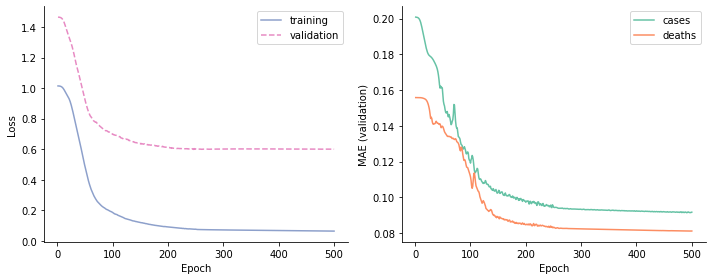

In [ ]:
COACH.setup(500, 100)
COACH.splitTimeSeries(66,20,25,blocking=False,explain=True) # 10 blocos progressivos
COACH.normalizeZeroMean()
recs1 = COACH.crossValidation(template1, L_RATE, [2, 0.25], MODALS)
COACH.plotCosts()


Fold #01:
|| EPOCH  500/ 500 |   2.17 min | MAE cases =  0.076531 | MAE deaths = 0.092489 ||

Fold #02:
|| EPOCH  500/ 500 |   2.47 min | MAE cases =  0.100354 | MAE deaths = 0.074958 ||

Fold #03:
|| EPOCH  500/ 500 |   2.97 min | MAE cases =  0.095498 | MAE deaths = 0.090402 ||

Fold #04:
|| EPOCH  500/ 500 |   3.47 min | MAE cases =  0.142459 | MAE deaths = 0.076657 ||

Fold #05:
|| EPOCH  500/ 500 |   3.98 min | MAE cases =  0.083915 | MAE deaths = 0.064703 ||

Fold #06:
|| EPOCH  500/ 500 |   4.48 min | MAE cases =  0.068502 | MAE deaths = 0.056354 ||

Fold #07:
|| EPOCH  500/ 500 |   4.98 min | MAE cases =  0.106430 | MAE deaths = 0.045754 ||

Fold #08:
|| EPOCH  500/ 500 |   5.48 min | MAE cases =  0.093546 | MAE deaths = 0.058063 ||

Fold #09:
|| EPOCH  500/ 500 |   6.01 min | MAE cases =  0.116230 | MAE deaths = 0.068052 ||

Fold #10:
|| EPOCH  500/ 500 |   6.52 min | MAE cases =  0.125152 | MAE deaths = 0.075585 ||




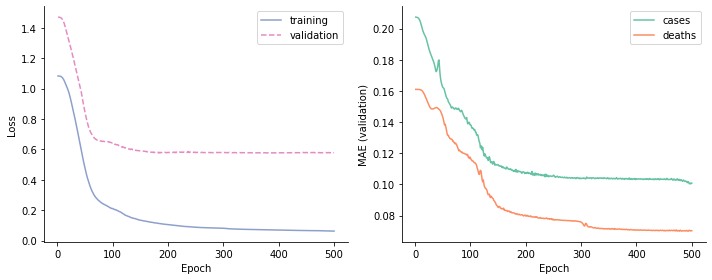

In [ ]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# fit definitivo
COACH.setup(500)
#COACH.splitTimeSeries(66,20,25,blocking=False,explain=False)
COACH.validation = False
COACH.normalizeZeroMean()
recs1 = COACH.crossValidation(template1, L_RATE, [2, 0.5], MODALS)
COACH.saveState(recs1, 'records/m1')
COACH.plotCosts()

|| EPOCH   30/ 150 |   2.56 min | MAE cases =  0.823574 | MAE deaths = 0.687670 ||
|| EPOCH   60/ 150 |   5.13 min | MAE cases =  0.793998 | MAE deaths = 0.653790 ||
|| EPOCH   90/ 150 |   7.68 min | MAE cases =  0.782183 | MAE deaths = 0.641027 ||
|| EPOCH  120/ 150 |  10.25 min | MAE cases =  0.782535 | MAE deaths = 0.626567 ||
|| EPOCH  150/ 150 |  12.80 min | MAE cases =  0.781561 | MAE deaths = 0.617902 ||




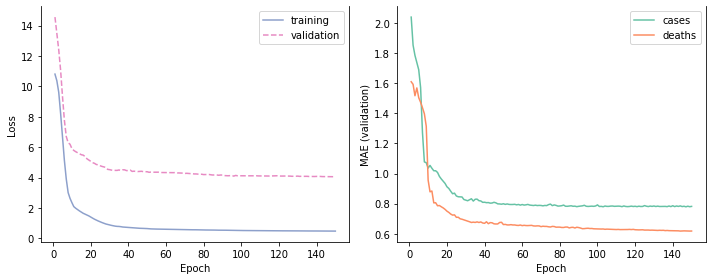

In [ ]:
COACH.setup(150,30)
#COACH.splitTimeSeries(66,20,25,blocking=False,explain=False)
COACH.validation = False
COACH.normalizeZeroMean()

stgcn1x = COACH.copyArchitecture(template1)
optim1x = tc.optim.Adam(stgcn1x.parameters(), lr=L_RATE)
schlr1x = tc.optim.lr_scheduler.StepLR(optim1x, 150/3, 0.5)
log1x = COACH.fit(stgcn1x, optim1x, schlr1x, list(zip(
        COACH.getFolds('tv'), 
        COACH.getFolds('te')
    )), COACH.getMeshMask(MODALS), True)
rec1x = [stgcn1x, log1x]

COACH.updateMeasures([rec1x])
COACH.saveState([rec1x], 'records/m1x')
COACH.plotCosts()

## Template 2

- DoubleGatedGCN v2 with Tanshrink as output activation function
- 1 hop at spatial recurrence step
- progressive ts split (10 folds)
- dataset normalized by zero mean
- batch normalization between temporal rec and mlp
- no dropout

(tr) 291
(vl) 200
(te) 250
blocking split: disabled
fold base size: 111
number of folds: 10
days left: 0 


Fold #01:
|| EPOCH   20/ 180 |   0.07 min | MAE cases =  0.070453 | MAE deaths = 0.102323 ||
|| EPOCH   40/ 180 |   0.13 min | MAE cases =  0.057458 | MAE deaths = 0.083942 ||
|| EPOCH   60/ 180 |   0.20 min | MAE cases =  0.055860 | MAE deaths = 0.082726 ||
|| EPOCH   80/ 180 |   0.26 min | MAE cases =  0.050434 | MAE deaths = 0.075077 ||
|| EPOCH  100/ 180 |   0.33 min | MAE cases =  0.062321 | MAE deaths = 0.080862 ||
|| EPOCH  120/ 180 |   0.39 min | MAE cases =  0.047995 | MAE deaths = 0.077091 ||
|| EPOCH  140/ 180 |   0.45 min | MAE cases =  0.047309 | MAE deaths = 0.076184 ||
|| EPOCH  160/ 180 |   0.52 min | MAE cases =  0.046486 | MAE deaths = 0.079785 ||
|| EPOCH  180/ 180 |   0.58 min | MAE cases =  0.046917 | MAE deaths = 0.075167 ||

Fold #02:
|| EPOCH   20/ 180 |   0.08 min | MAE cases =  0.117052 | MAE deaths = 0.111697 ||
|| EPOCH   40/ 180 |   0.17 min | MAE cas

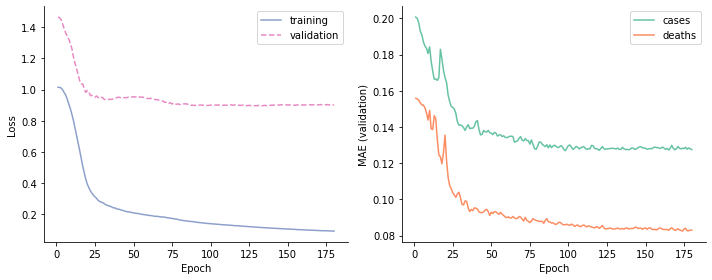

In [ ]:
# parameters choice
COACH.setup(180, 30)
COACH.splitTimeSeries(66,20,25,blocking=False,explain=True) # 10 blocos progressivos
COACH.normalizeZeroMean()
recs2 = COACH.crossValidation(template2, L_RATE*5, [2, 0.5], MODALS)
COACH.plotCosts()

(tr) 291
(vl) 200
(te) 250
blocking split: disabled
fold base size: 111
number of folds: 10
days left: 0 


Fold #01:
|| EPOCH   40/ 200 |   0.11 min | MAE cases =  0.047683 | MAE deaths = 0.091106 ||
|| EPOCH   80/ 200 |   0.21 min | MAE cases =  0.047780 | MAE deaths = 0.076014 ||
|| EPOCH  120/ 200 |   0.32 min | MAE cases =  0.044785 | MAE deaths = 0.067624 ||
|| EPOCH  160/ 200 |   0.42 min | MAE cases =  0.043899 | MAE deaths = 0.068947 ||
|| EPOCH  200/ 200 |   0.53 min | MAE cases =  0.046629 | MAE deaths = 0.065552 ||

Fold #02:
|| EPOCH   40/ 200 |   0.14 min | MAE cases =  0.124078 | MAE deaths = 0.115645 ||
|| EPOCH   80/ 200 |   0.28 min | MAE cases =  0.104281 | MAE deaths = 0.111574 ||
|| EPOCH  120/ 200 |   0.43 min | MAE cases =  0.100878 | MAE deaths = 0.103101 ||
|| EPOCH  160/ 200 |   0.57 min | MAE cases =  0.102176 | MAE deaths = 0.101960 ||
|| EPOCH  200/ 200 |   0.71 min | MAE cases =  0.102416 | MAE deaths = 0.102283 ||

Fold #03:
|| EPOCH   40/ 200 |   0.20 mi

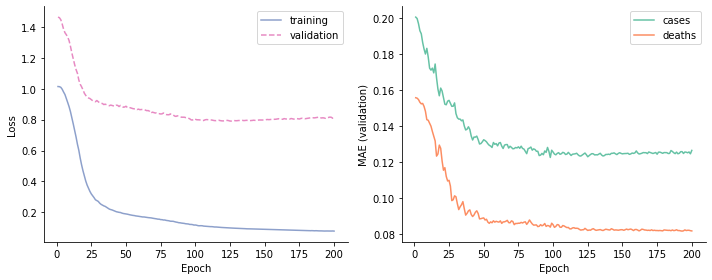

In [ ]:
# parameters choice
COACH.setup(200, 40)
COACH.splitTimeSeries(66,20,25,blocking=False,explain=True) # 10 blocos progressivos
COACH.normalizeZeroMean()
recs2 = COACH.crossValidation(template2, L_RATE*5, [2, 0.5], MODALS)
COACH.plotCosts()


Fold #01:
|| EPOCH  200/ 200 |   0.68 min | MAE cases =  0.086556 | MAE deaths = 0.091001 ||

Fold #02:
|| EPOCH  200/ 200 |   0.87 min | MAE cases =  0.125161 | MAE deaths = 0.102166 ||

Fold #03:
|| EPOCH  200/ 200 |   1.05 min | MAE cases =  0.151827 | MAE deaths = 0.107413 ||

Fold #04:
|| EPOCH  200/ 200 |   1.23 min | MAE cases =  0.155596 | MAE deaths = 0.096459 ||

Fold #05:
|| EPOCH  200/ 200 |   1.41 min | MAE cases =  0.115903 | MAE deaths = 0.078853 ||

Fold #06:
|| EPOCH  200/ 200 |   1.60 min | MAE cases =  0.100408 | MAE deaths = 0.072423 ||

Fold #07:
|| EPOCH  200/ 200 |   1.78 min | MAE cases =  0.086501 | MAE deaths = 0.052387 ||

Fold #08:
|| EPOCH  200/ 200 |   1.96 min | MAE cases =  0.145743 | MAE deaths = 0.085038 ||

Fold #09:
|| EPOCH  200/ 200 |   2.14 min | MAE cases =  0.166172 | MAE deaths = 0.080949 ||

Fold #10:
|| EPOCH  200/ 200 |   2.33 min | MAE cases =  0.162967 | MAE deaths = 0.088728 ||




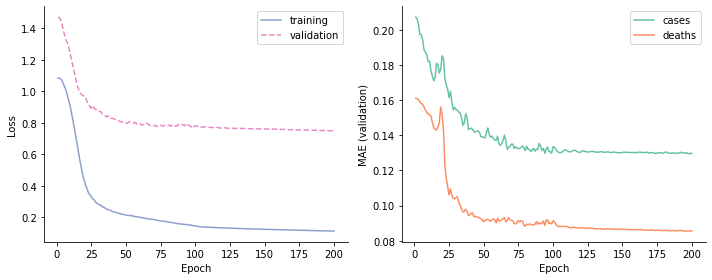

In [ ]:
# fit definitivo
COACH.setup(200)
COACH.validation = False
COACH.normalizeZeroMean()
recs2 = COACH.crossValidation(template2, L_RATE*5, [2, 0.2], MODALS)
COACH.saveState(recs2, 'records/m2x')
COACH.plotCosts()


Fold #01:
|| EPOCH  200/ 200 |   0.74 min | MAE cases =  0.095083 | MAE deaths = 0.104783 ||

Fold #02:
|| EPOCH  200/ 200 |   0.93 min | MAE cases =  0.117292 | MAE deaths = 0.089499 ||

Fold #03:
|| EPOCH  200/ 200 |   1.14 min | MAE cases =  0.124272 | MAE deaths = 0.086951 ||

Fold #04:
|| EPOCH  200/ 200 |   1.34 min | MAE cases =  0.123979 | MAE deaths = 0.083505 ||

Fold #05:
|| EPOCH  200/ 200 |   1.53 min | MAE cases =  0.101130 | MAE deaths = 0.076482 ||

Fold #06:
|| EPOCH  200/ 200 |   1.74 min | MAE cases =  0.085465 | MAE deaths = 0.059550 ||

Fold #07:
|| EPOCH  200/ 200 |   1.95 min | MAE cases =  0.075007 | MAE deaths = 0.047631 ||

Fold #08:
|| EPOCH  200/ 200 |   2.12 min | MAE cases =  0.115795 | MAE deaths = 0.077758 ||

Fold #09:
|| EPOCH  200/ 200 |   2.30 min | MAE cases =  0.151619 | MAE deaths = 0.078915 ||

Fold #10:
|| EPOCH  200/ 200 |   2.49 min | MAE cases =  0.174392 | MAE deaths = 0.083675 ||




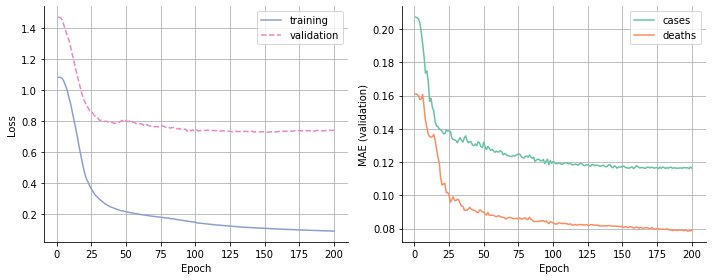

In [ ]:
# fit definitivo
COACH.setup(200)
COACH.validation = False
COACH.normalizeZeroMean()
recs2 = COACH.crossValidation(template2, L_RATE*5, [2, 0.5], MODALS)
COACH.saveState(recs2, 'records/m2')
COACH.plotCosts()

## Template 3

- DoubleGatedGCN v3 with Tanshrink as output activation function
- 1 hop at spatial recurrence step
- progressive ts split (10 folds)
- dataset normalized by zero mean
- no dropout

In [ ]:
from torch.nn.modules.dropout import Dropout
class DoubleGatedGCNv3(tc.nn.Module):
    
    def __init__(self, params, tau, loop=1, dropout=0, channels=4):
        super(DoubleGatedGCNv3, self).__init__()

        self.delay = int (tau if tau > 1 else 1) - 1
        self.samples = params['municipios']
        self.features = params['dim_estat'] + params['dim_dinam']
        self.hidden = self.features * (self.delay + 1)
        self.output = params['dim_dinam']
        
        self.device = ('cuda:0' if tc.cuda.is_available() else 'cpu')
        
        self.inferState = tc.nn.Sequential(
            tc.nn.Dropout(p=dropout),
            tc.nn.Linear(self.output, self.features),
            tc.nn.ReLU(),
            tc.nn.Linear(self.features, self.features),
            tc.nn.ReLU(),
            tc.nn.Linear(self.features, self.features),
            tc.nn.Tanhshrink()
        )
        self.inferContext = tc.nn.Sequential(
            tc.nn.Dropout(p=dropout),
            tc.nn.Linear(self.features, self.hidden),
            tc.nn.ReLU(),
            tc.nn.Linear(self.hidden, self.hidden),
            tc.nn.ReLU(),
            tc.nn.Linear(self.hidden, self.hidden),
            tc.nn.Tanhshrink()
        )
        self.gnn = [ 
        	tg.nn.GatedGraphConv(out_channels=self.features, num_layers=loop).to(self.device)
        	for i in range(channels) 
        ]
        self.nrm = [ 
            tc.nn.BatchNorm1d(self.features).to(self.device)
        	for i in range(channels) 
        ]
        self.cnn = tc.nn.Conv1d(channels, 1, kernel_size=1, bias=False)
        self.rec = tc.nn.GRUCell(self.hidden, self.hidden)
        self.mlp = tc.nn.Sequential(
            tc.nn.Dropout(p=dropout),
            tc.nn.ReLU(),
            tc.nn.Linear(self.hidden, self.hidden),
            tc.nn.ReLU(),
            tc.nn.Linear(self.hidden, self.hidden),
            tc.nn.ReLU(),
            tc.nn.Linear(self.hidden, self.output),
            tc.nn.Tanhshrink()
        )
    
    def forward(self, Xd, Xs, A, W, mask, H=None):
        S_init = self.inferState(Xd[0])
        S = [ S_init.clone() for t in range(self.delay) ]
        H = self.inferContext(S_init) if H is None else H
        Y = []

        for t in range(Xd.size(0)):
            X = tc.cat([Xd[t], Xs], dim=1)
            C = tc.stack([ 
                    F.relu(n(g(X, A[:, m], W[m]))) 
                    for m, g, n in zip(mask, self.gnn, self.nrm) 
                ], dim=1)
            Z = F.relu(self.cnn(C)).view(-1, self.features)
            S.append(Z)
            U = tc.cat(S, dim=1)
            H = self.rec(U, H)
            Y.append(self.mlp(H))
            del S[0]
        
        while len(S):
            del S[0]
        return tc.stack(Y), H

    def forecast(self, Xd, Xs, A, W, mask, H=None, qt_days=1):
        S_init = self.inferState(Xd[0])
        S = [ S_init.clone() for t in range(self.delay) ]
        H = self.inferContext(S_init) if H is None else H
        Y = []
        
        # série temporal informada
        for t in range(Xd.size(0)):
            X = tc.cat([Xd[t], Xs], dim=1)
            C = tc.stack([ 
                    F.relu(n(g(X, A[:, m], W[m]))) 
                    for m, g, n in zip(mask, self.gnn, self.nrm) 
                ], dim=1)
            # torch.Size([5570, 4, 5]) torch.Size([5570, 5])
            Z = F.relu(self.cnn(C)).view(-1, self.features)
            S.append(Z)
            U = tc.cat(S, dim=1)
            H = self.rec(U, H)
            Y.append(self.mlp(H))
            del S[0]
        
        # série temporal prevista
        for t in range(qt_days):
            X = tc.cat([Y[-1], Xs], dim=1)
            C = tc.stack([ 
                    F.relu(n(g(X, A[:, m], W[m]))) 
                    for m, g, n in zip(mask, self.gnn, self.nrm) 
                ], dim=1)
            # torch.Size([5570, 4, 5]) torch.Size([5570, 5])
            Z = F.relu(self.cnn(C)).view(-1, self.features)
            S.append(Z)
            U = tc.cat(S, dim=1)
            H = self.rec(U, H)
            Y.append(self.mlp(H))
            del S[0]
        
        while len(S):
            del S[0]
        return tc.stack(Y), H

template2 = DoubleGatedGCNv3(DATASET.graph_info, TAU, loop=1, dropout=0.01, channels=len(MODALS)).to(DEVICE)

In [ ]:
# parameters choice
COACH.setup(300, 100)
COACH.splitTimeSeries(66,20,25,blocking=False,explain=True) # 10 blocos progressivos
COACH.normalizeZeroMean()
recs2 = COACH.crossValidation(template2, L_RATE, [2, 0.2], MODALS)
COACH.plotCosts()

(tr) 291
(vl) 200
(te) 250
blocking split: disabled
fold base size: 111
number of folds: 10
days left: 0 


Fold #01:
|| EPOCH   50/ 400 |   0.46 min | MAE cases =  0.155566 | MAE deaths = 0.108946 ||
|| EPOCH  100/ 400 |   0.92 min | MAE cases =  0.044922 | MAE deaths = 0.065121 ||
|| EPOCH  150/ 400 |   1.37 min | MAE cases =  0.042737 | MAE deaths = 0.062024 ||
|| EPOCH  200/ 400 |   1.84 min | MAE cases =  0.041573 | MAE deaths = 0.060128 ||
|| EPOCH  250/ 400 |   2.30 min | MAE cases =  0.041118 | MAE deaths = 0.059861 ||
|| EPOCH  300/ 400 |   2.75 min | MAE cases =  0.040873 | MAE deaths = 0.059761 ||
|| EPOCH  350/ 400 |   3.20 min | MAE cases =  0.040740 | MAE deaths = 0.059595 ||
|| EPOCH  400/ 400 |   3.66 min | MAE cases =  0.040382 | MAE deaths = 0.059072 ||

Fold #02:
|| EPOCH   50/ 400 |   0.62 min | MAE cases =  0.135138 | MAE deaths = 0.152458 ||
|| EPOCH  100/ 400 |   1.23 min | MAE cases =  0.135815 | MAE deaths = 0.134925 ||
|| EPOCH  150/ 400 |   1.85 min | MAE cas

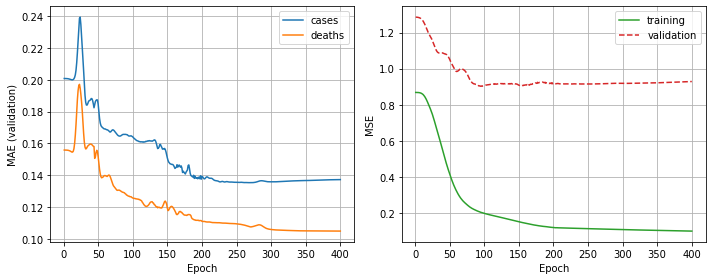

In [ ]:
# parameters choice
COACH.setup(400, 50)
COACH.splitTimeSeries(66,20,25,blocking=False,explain=True) # 10 blocos progressivos
COACH.normalizeZeroMean()
recs2 = COACH.crossValidation(template2, L_RATE, [2, 0.25], MODALS)
COACH.plotCosts()


Fold #01:
|| EPOCH  400/ 400 |  31.77 min | MAE cases =  0.094118 | MAE deaths = 0.103060 ||

Fold #02:
|| EPOCH  400/ 400 |  40.13 min | MAE cases =  0.153436 | MAE deaths = 0.106991 ||

Fold #03:
|| EPOCH  400/ 400 |  48.59 min | MAE cases =  0.195814 | MAE deaths = 0.134270 ||

Fold #04:
|| EPOCH  400/ 400 |  57.19 min | MAE cases =  0.136127 | MAE deaths = 0.096359 ||

Fold #05:
|| EPOCH  400/ 400 |  65.61 min | MAE cases =  0.150816 | MAE deaths = 0.104516 ||

Fold #06:
|| EPOCH  400/ 400 |  74.14 min | MAE cases =  0.131983 | MAE deaths = 0.128405 ||

Fold #07:
|| EPOCH  400/ 400 |  82.63 min | MAE cases =  0.132915 | MAE deaths = 0.106799 ||

Fold #08:
|| EPOCH  400/ 400 |  91.69 min | MAE cases =  0.197551 | MAE deaths = 0.120151 ||

Fold #09:
|| EPOCH  400/ 400 | 100.55 min | MAE cases =  0.188341 | MAE deaths = 0.115229 ||

Fold #10:
|| EPOCH  400/ 400 | 115.09 min | MAE cases =  0.166552 | MAE deaths = 0.099079 ||




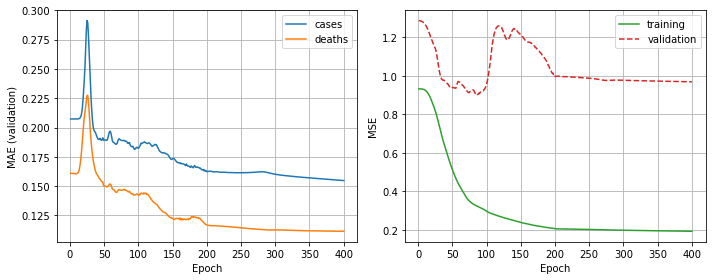

In [ ]:
COACH.setup(400)
#COACH.splitTimeSeries(66,20,25,blocking=False,explain=False)
COACH.validation = False
COACH.normalizeZeroMean()
recs2 = COACH.crossValidation(template2, L_RATE, [2, 0.1], MODALS)
COACH.saveState(recs2, 'records/v2')
COACH.plotCosts()

# Forecasting Visualization

## Functions

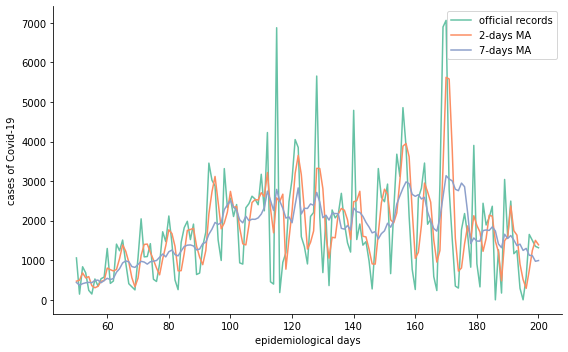

In [ ]:
def smoothingDiff(geocode, t):
    if (t is None):
        t = [0, DATASET.graph_info['dias']]

    idx = DATASET.geocode_index[geocode]
    name = COACH.name_list[idx]
    days = range(DATASET.graph_info['dias'])
    x_raw = DATASET.vertex_tseries[:, idx, 0]
    x_ma2 = COACH.movingAvg(x_raw, 2)
    x_ma7 = COACH.movingAvg(x_raw, 7)

    df = pd.DataFrame(data={
        'day': days[t[0]:t[1]],
        'official records': x_raw[t[0]:t[1]],
        '2-days MA': x_ma2[t[0]:t[1]],
        '7-days MA': x_ma7[t[0]:t[1]]
    }).melt(id_vars='day', var_name='smoothness', value_name='record')

    plt.figure(figsize=(8,5))
    sns.lineplot(x='day', y='record', hue='smoothness', data=df)
    plt.xlabel("epidemiological days")
    plt.ylabel("cases of Covid-19")
    plt.tight_layout()
    plt.legend()
    plt.savefig('images/forecasts/ts_smoothing.png', dpi=150)
    plt.show()

smoothingDiff(GEOCODE['RMSP'][0], t=[50,201]) # São Paulo

In [ ]:
# previsão diária utilizando sempre como
# entrada os dados reais de dias anteriores
def oneDayForecast(model, list_codes, mesh, cumulative_plot=True, 
                   adjust=True, curves=[True,True], simple_title=False, suffix=None):
    n = len(list_codes)
    m = np.sum(curves)
    t_max = DATASET.graph_info['dias']
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':False})
    fig, axes = plt.subplots(n, m, figsize=(9*m, 5*n), squeeze=False)

    with tc.no_grad():
        days = tc.tensor(range(t_max))
        X_in = COACH.undoNorm(COACH.Xd).cpu() # série histórica informada
        X_pr = COACH.undoNorm(model.forward(COACH.Xd, COACH.Xs, COACH.A, COACH.W, 
                                            COACH.getMeshMask(mesh))[0]).cpu() # série histórica prevista
        if adjust:
            X_pr = F.relu(X_pr)

        if cumulative_plot:
            cX_in = COACH.cumulative(X_in)
            cX_pr = COACH.cumulative(X_pr)

    for j, code in enumerate(list_codes):
        if code is not None:
            idx = DATASET.geocode_index[code]
            conectivo = 'Covid-19 '
            nome = DATASET.vertex_attr[idx]['municipio']
        else:
            idx = 0
            conectivo = 'Covid-19 '
            nome = 'Brazil'
            X_in = X_in.sum(1).view(t_max,1,2)
            X_pr = X_pr.sum(1).view(t_max,1,2)
            # mudança de escala e offset para anular o bias acumulado
            ti, tf = 30, COACH.mbatch_size * 2
            X_pr = (X_pr - X_pr[20])
            X_pr = X_pr * ((X_in[ti:] - X_in[20]) / (X_pr[ti:] - X_pr[20])).mean(0)
            # re-cálculo do acumulado
            cX_in = COACH.cumulative(X_in)
            cX_pr = COACH.cumulative(X_pr)
        ax = axes[j]

        for i, t in enumerate(['cases in ', 'deaths in ']):
            if not curves[i]:
                continue;
            
            k = np.min([m-1, i]) # i: curva a ser exibida, k: coluna do gráfico
            fig_title = nome if simple_title else str (conectivo + t + nome)

            #ax[k].plot(days,   X_in[:t_max, idx, i], label='real')
            #ax[k].plot(days+1, X_pr[:t_max, idx, i], label='forecast')
            sns.lineplot(x=days  , y=X_in[:t_max, idx, i], label='real', ax=ax[k])
            sns.lineplot(x=days+1, y=X_pr[:t_max, idx, i], label='forecast', ax=ax[k])
            ax[k].set(ylabel='daily record', xlabel='pandemic day', title=fig_title)
            ax[k].legend(loc='upper left')
            #ax[k].grid()

            if cumulative_plot:
                tx = ax[k].twinx()
                tx.plot(days,   cX_in[:t_max, idx, i], '--', alpha=0.8)
                tx.plot(days+1, cX_pr[:t_max, idx, i], '--', alpha=0.8)
                tx.set(ylabel='accumulated record')
        
        if code is None:
            break
    
    plt.tight_layout()
    figname = ('brazil' if list_codes[0] is None else '-'.join([ str(i) for i in list_codes ])) + ('_' + suffix if suffix is not None else '')
    plt.savefig('images/forecasts/records_'+figname+'.png', dpi=150)
    plt.show()
    
    print('\n\n')
    plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})

# curva 'previsto' coletada através da previsão de apenas 'dt' dias à frente
# tendo como entrada a série temporal informada por 't0' dias e após isso
# é utilizada a saída prevista como entrada da rede
def nDaysForecast(model, list_codes, mesh, dt=None, adjust=True):
    qt_days = DATASET.graph_info['dias']
    if dt is None:
        dt = [int (qt_days * .8), int (qt_days * .2)]
    
    t_i = 0 if dt[0] < 120 else dt[0]-120
    t_f = dt[0] + dt[1]
    t_p = t_f if t_f <= qt_days else qt_days

    n = len(list_codes)
    fig, axes = plt.subplots(n, 2, figsize=(18, 5*n), squeeze=False)
    palette = sns.color_palette()
    
    with tc.no_grad():
        days = tc.tensor(range(t_f))
        X_in = COACH.undoNorm(COACH.Xd).cpu() # série histórica informada
        X_ma = COACH.movingAvg(X_in, 7) # média móvel da entrada
        X_pr = COACH.undoNorm(model.forecast(COACH.Xd[ : dt[0] ], COACH.Xs, COACH.A, COACH.W, 
                                             COACH.getMeshMask(mesh), None, dt[1])[0]).cpu() # série histórica prevista
        if adjust:
            X_pr = F.relu(X_pr)

        for j, code in enumerate(list_codes):
            idx = DATASET.geocode_index[code]
            nome = 'em ' + DATASET.vertex_attr[idx]['municipio']
            ax = axes[j]
            
            for i, t in enumerate(['casos', 'mortes']):
                l1 = ax[i].plot(days[t_i   : dt[0]], X_in[t_i   : dt[0], idx, i], color=palette[0])
                l2 = ax[i].plot(days[dt[0] : t_p],   X_in[dt[0] : t_p,   idx, i], color=palette[2])
                l3 = ax[i].plot(days[dt[0] : t_f],   X_pr[dt[0] : t_f,   idx, i], color=palette[1])
                l4 = ax[i].plot(days[t_i   : t_p],   X_ma[t_i   : t_p,   idx, i], '--', color=palette[3], alpha=0.7)
            
                t = str (t + ' de Covid-19 ' + nome)
                ax[i].set(ylabel='Quantidade', xlabel='Dia', title=t)
                ax[i].legend((l1[0], l2[0], l3[0], l4[0]), ('informado', 'esperado', 'previsto', 'média móvel'))
                ax[i].grid()

    plt.tight_layout()
    plt.show()
    print('\n\n')

## Template 1

In [ ]:
len(recs1)

2

Model 1f0:
  -> training/test loss = 0.014/1.153


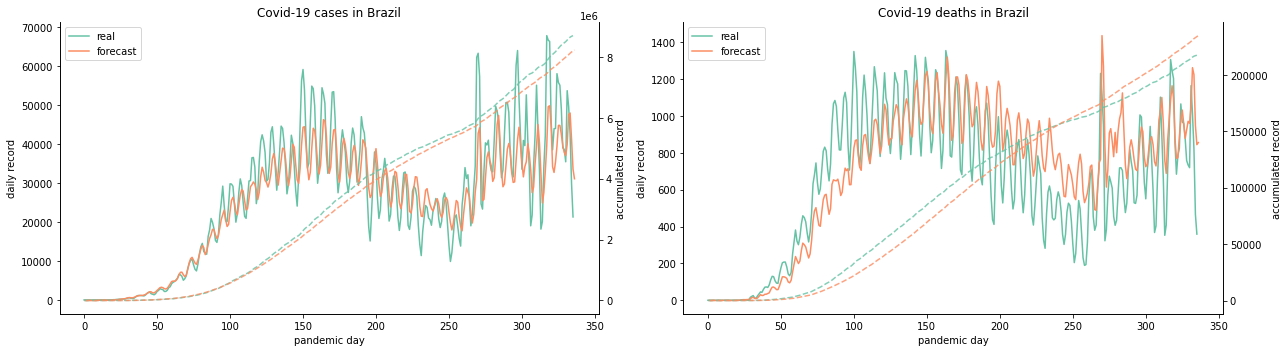




Model 1f1:
  -> training/test loss = 0.027/0.718


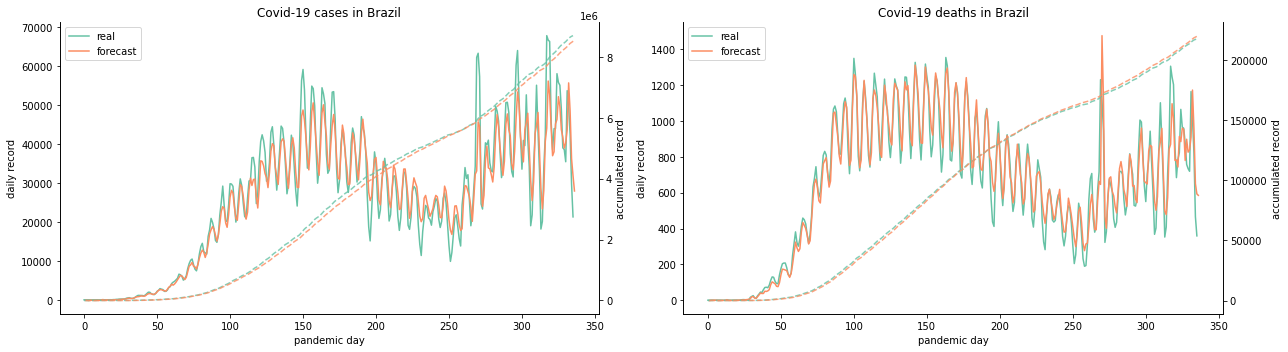




Model 1f2:
  -> training/test loss = 0.037/0.517


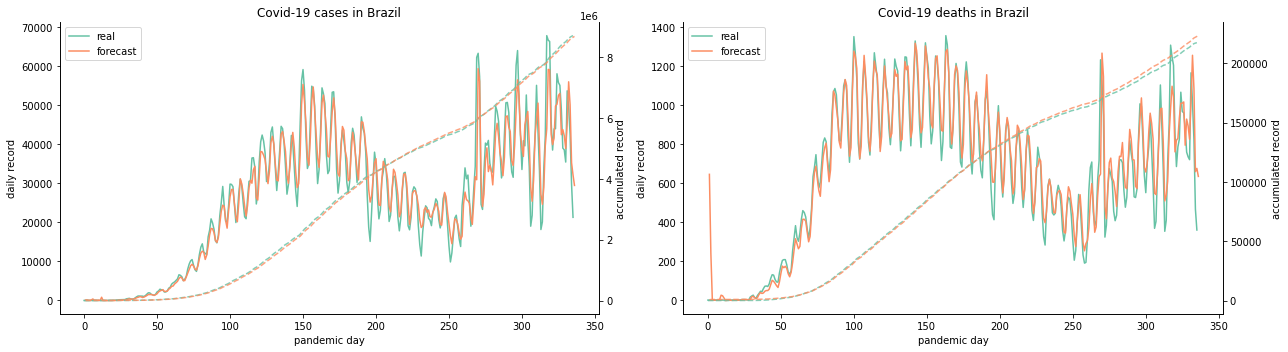




Model 1f3:
  -> training/test loss = 0.062/0.727


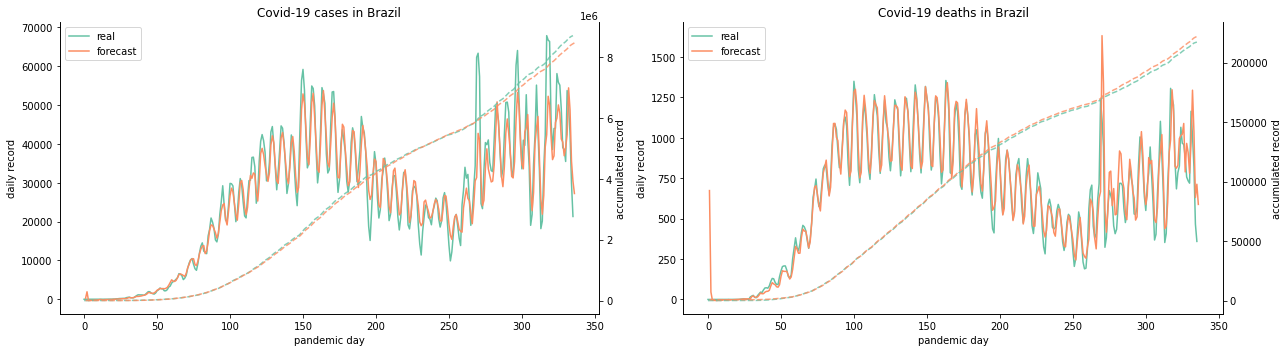




Model 1f4:
  -> training/test loss = 0.058/0.320


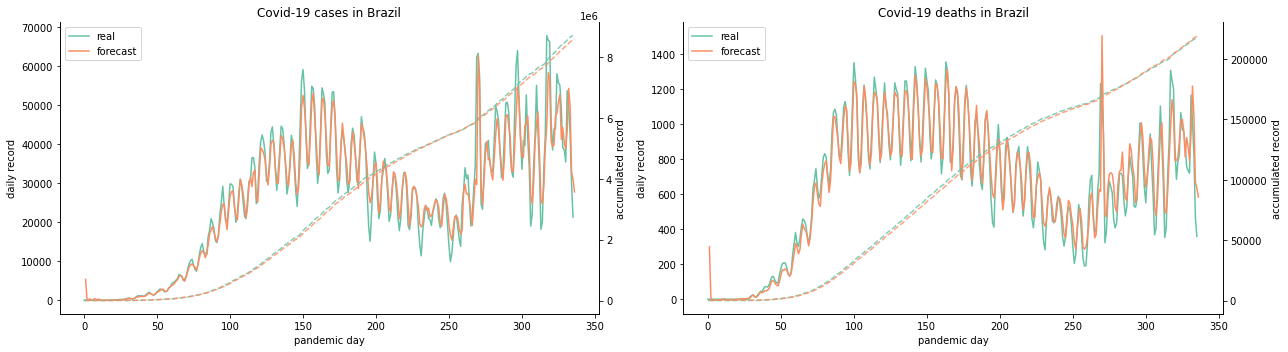




Model 1f5:
  -> training/test loss = 0.075/0.235


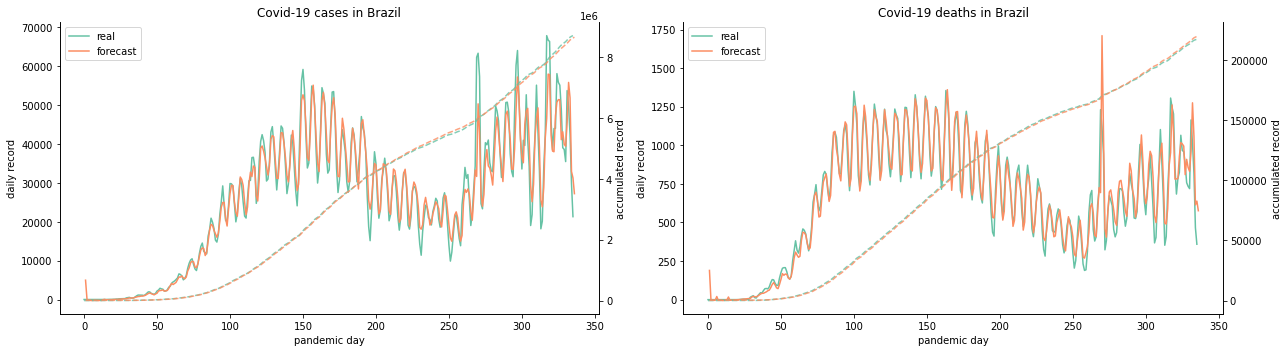




Model 1f6:
  -> training/test loss = 0.101/0.176


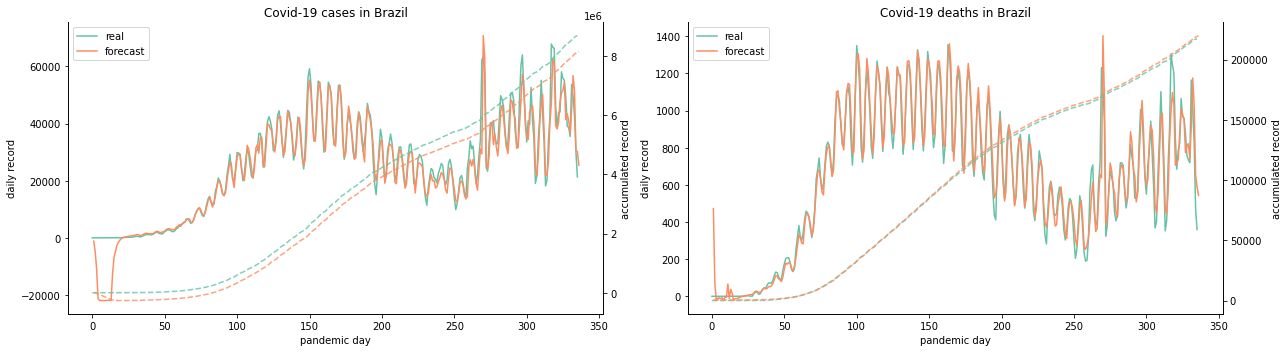




Model 1f7:
  -> training/test loss = 0.060/0.721


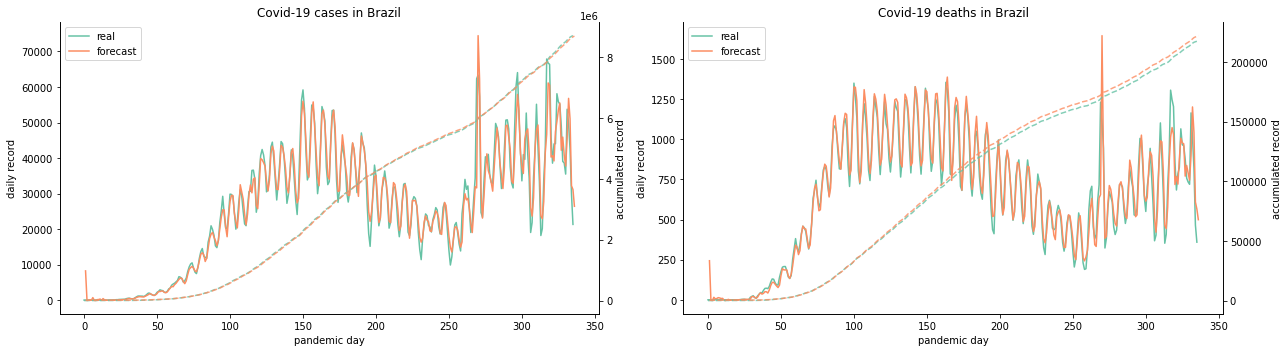




Model 1f8:
  -> training/test loss = 0.088/0.629


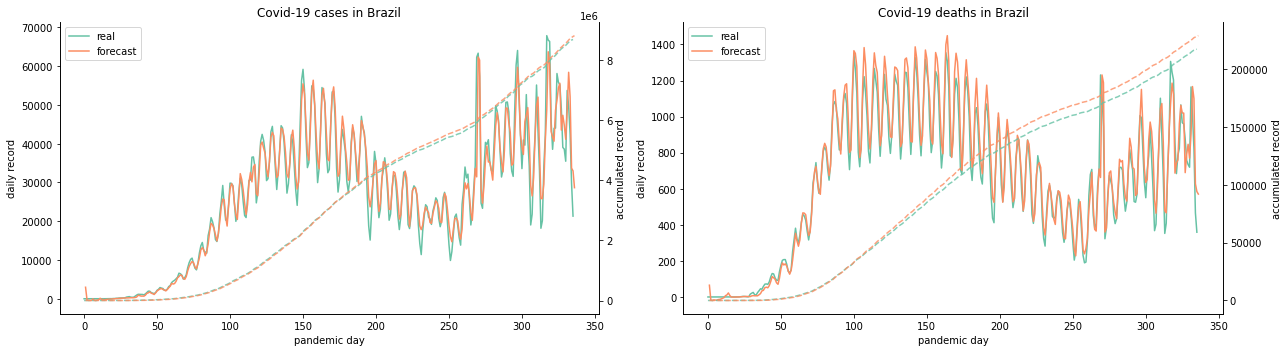




Model 1f9:
  -> training/test loss = 0.104/0.600


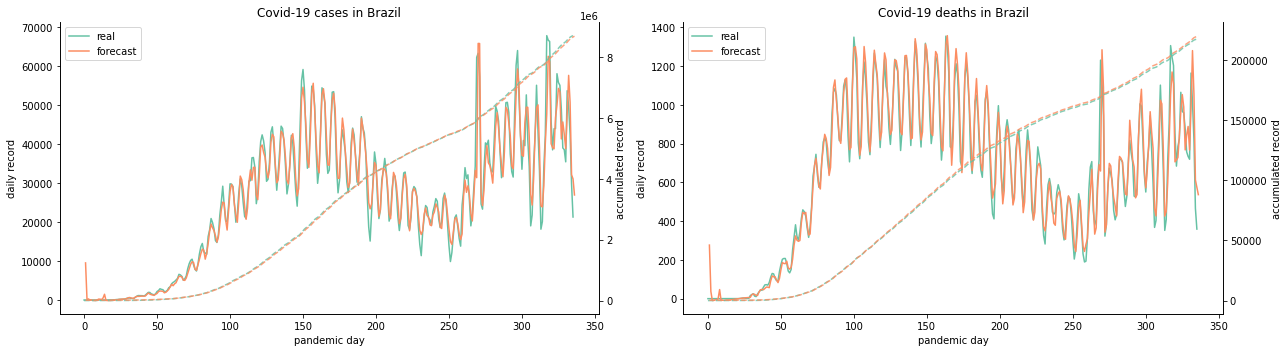

In [ ]:
# análise do modelo 1 em território nacional
recs1 = COACH.loadState(template1, 'records/m1')

for i, (net, data) in enumerate(recs1):
    tr_loss = data['loss'][0]
    te_loss = data['loss'][1]
    print('Model 1f%i:' % (i))
    print('  -> training/test loss = %.3f/%.3f' % (tr_loss[-1], te_loss[-1]))
    oneDayForecast(net, [None], MODALS, suffix=('stGCN-m1-f' + str(i)))

In [ ]:
chosen1 = recs1[5][0]
for m in ['FOCO', 'RMSP', 'BAIX', 'AERO', 'SOPR', 'MPEQ']:
    oneDayForecast(chosen1, GEOCODE[m], MODALS, suffix='stGCN-m1*')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
stgcn1x = COACH.loadState(template1, 'records/m1x')[0][0]
oneDayForecast(stgcn1x, [None], MODALS, suffix='stGCN-m1x')

for m in ['FOCO', 'RMSP', 'BAIX', 'AERO', 'SOPR', 'MPEQ']:
    oneDayForecast(stgcn1x, GEOCODE[m], MODALS, suffix='stGCN-m1x')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#for t_known in [100, 150, 300, 330]:
    #nDaysForecast(best1, GEOCODE['RMSP'], MODALS, [t_known, 20])

In [ ]:
# imagens para o artigo
#oneDayForecast(model1, GEOCODE['RMSP'][0:4], CHANNEL, curves=[True,False], simple_title=True)
#oneDayForecast(model1, GEOCODE['SOPR'][0:3], CHANNEL, curves=[True,False], simple_title=True)
#oneDayForecast(model1, GEOCODE['BAIX'][0:1], CHANNEL, curves=[True,False], simple_title=True)

## Template 1x

Model m1-f0:
  -> training/test loss = 0.013/0.678


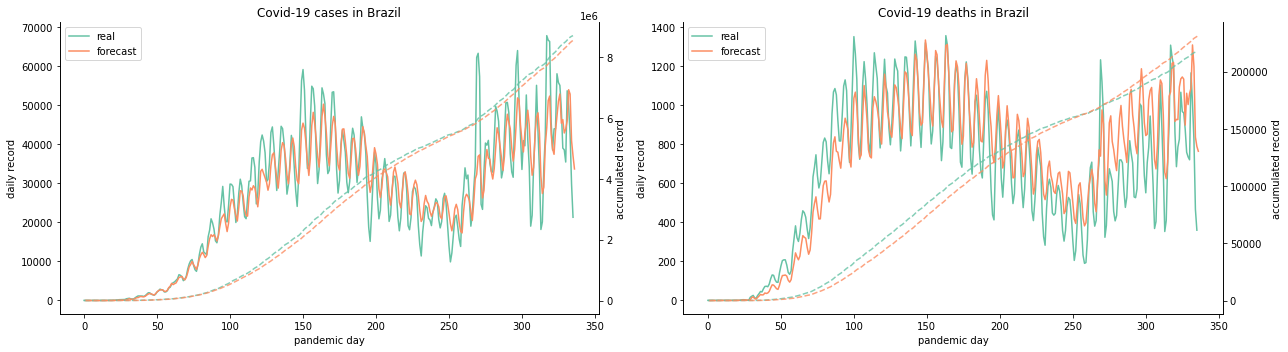




Model m1-f1:
  -> training/test loss = 0.022/0.984


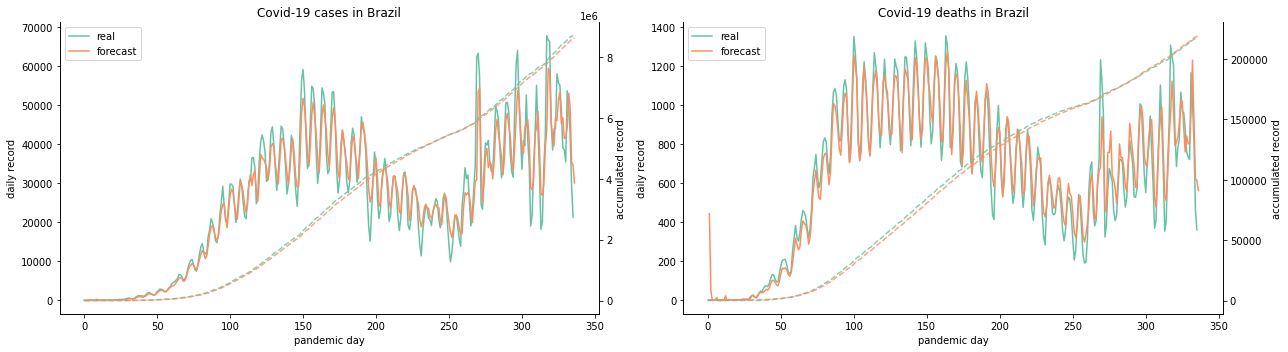




Model m1-f2:
  -> training/test loss = 0.040/0.625


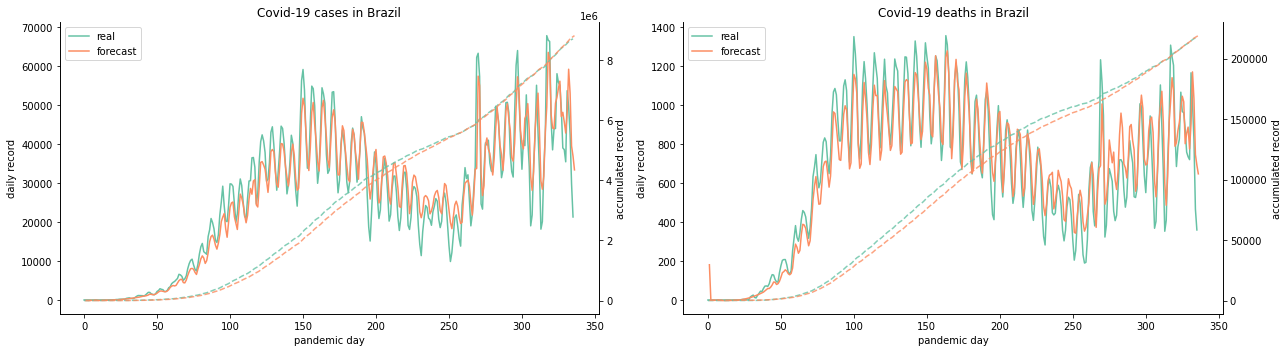




Model m1-f3:
  -> training/test loss = 0.042/0.389


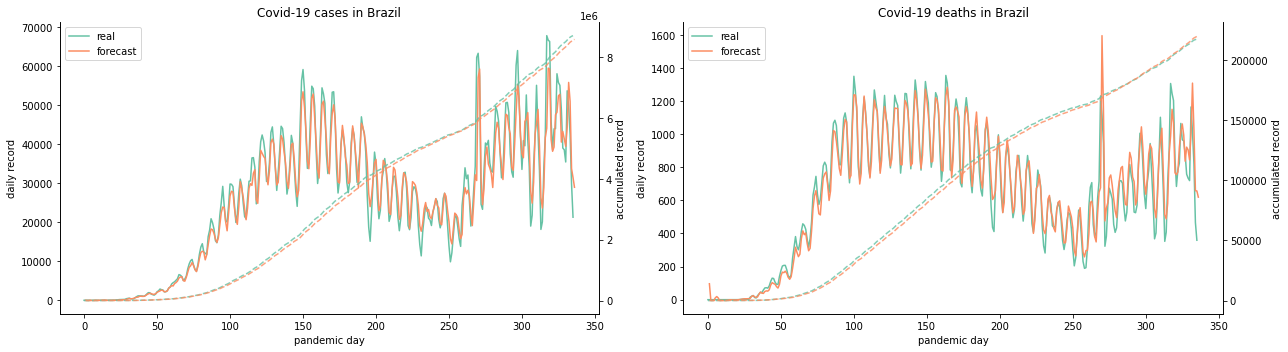




Model m1-f4:
  -> training/test loss = 0.052/0.345


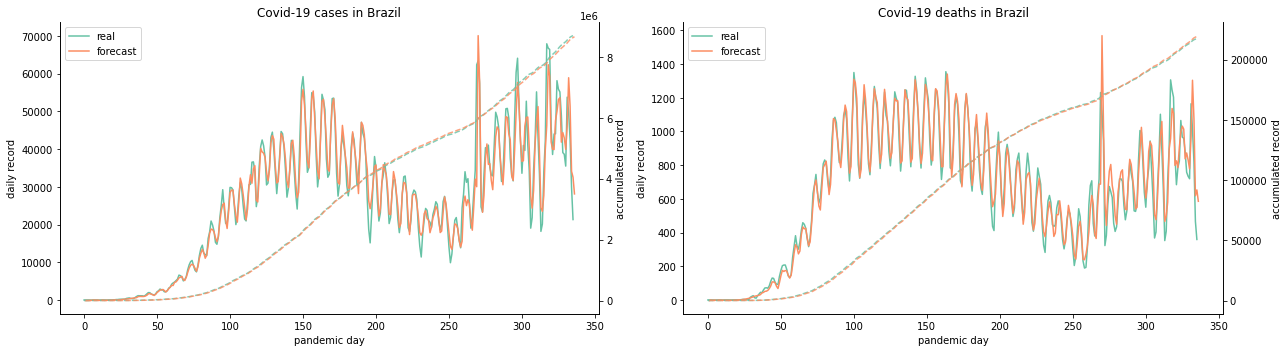




Model m1-f5:
  -> training/test loss = 0.086/0.197


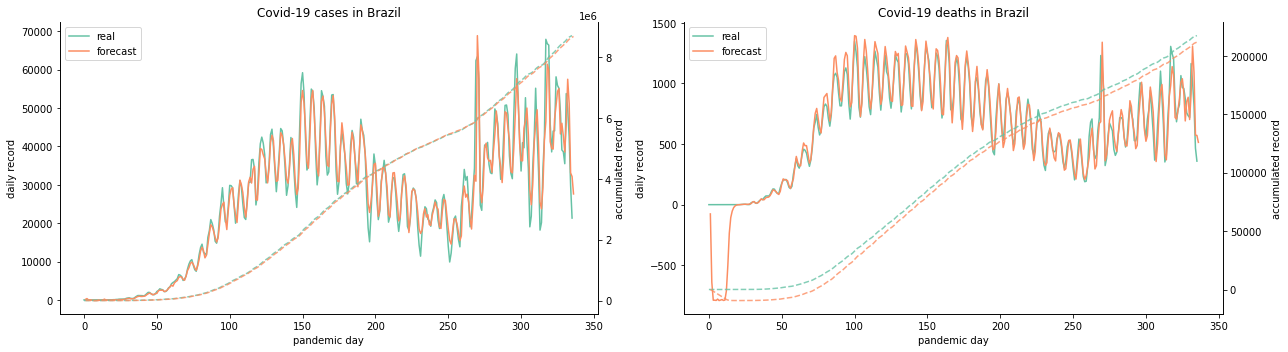




Model m1-f6:
  -> training/test loss = 0.068/0.290


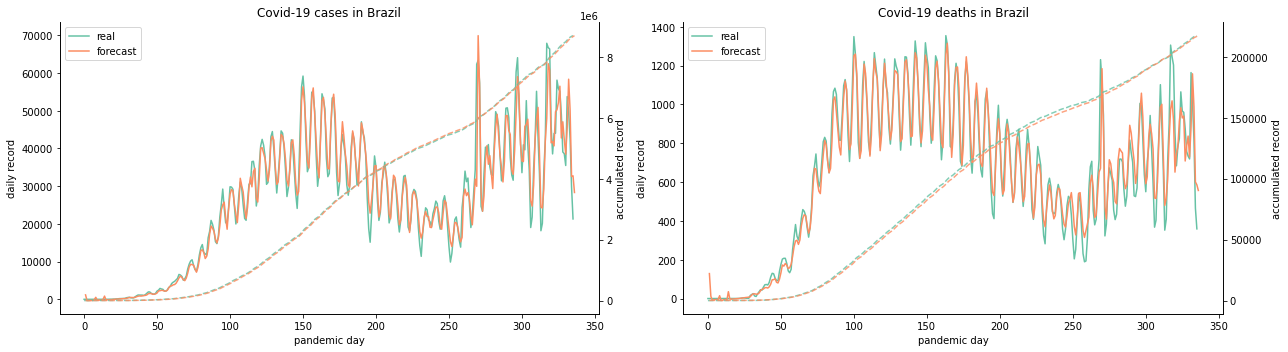




Model m1-f7:
  -> training/test loss = 0.059/0.833


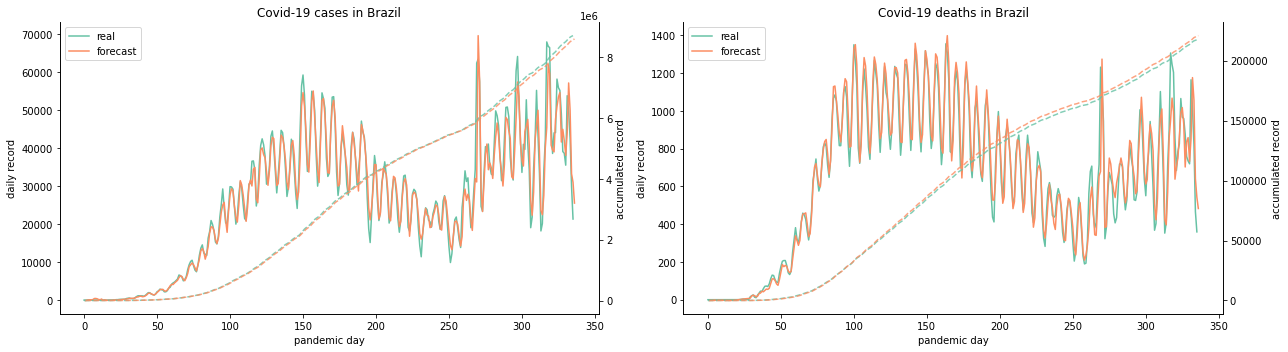




Model m1-f8:
  -> training/test loss = 0.091/0.567


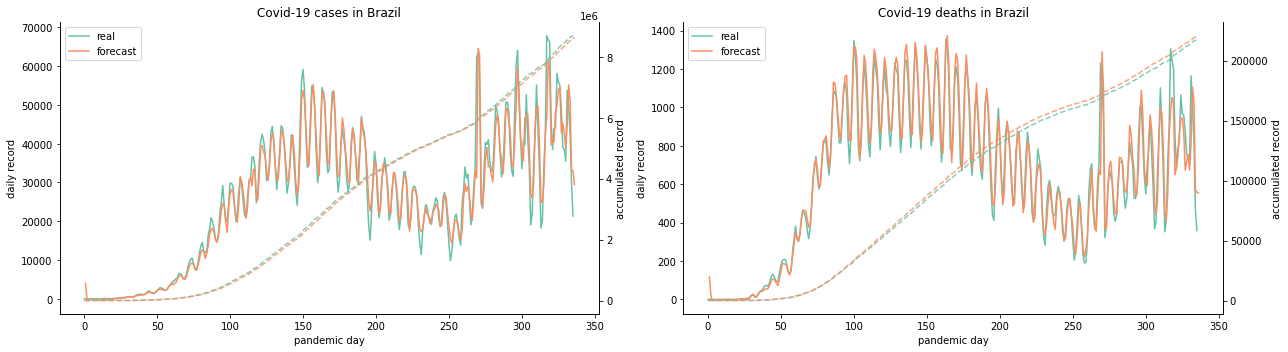




Model m1-f9:
  -> training/test loss = 0.087/0.574


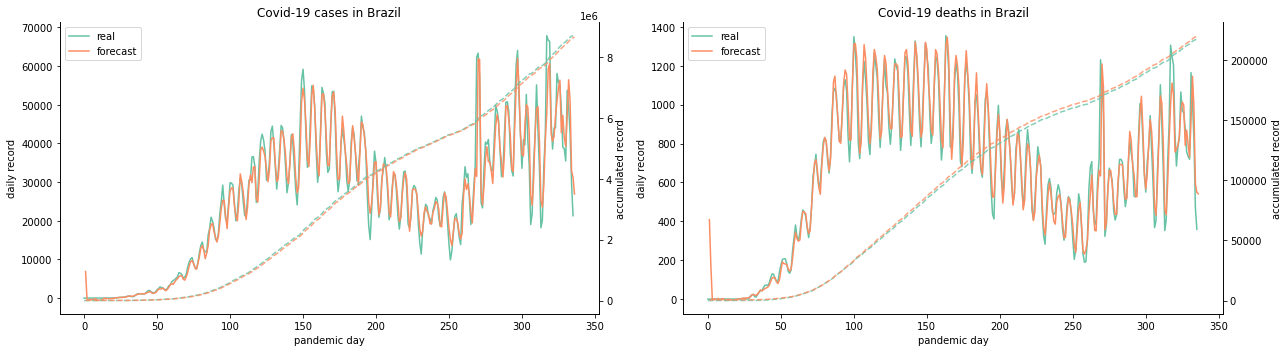

In [ ]:
# análise do modelo 2 em território nacional
recs1 = COACH.loadState(template1, 'records/m1x')

for i, (net, data) in enumerate(recs1):
    tr_loss = data['loss'][0]
    te_loss = data['loss'][1]
    print('Model m1-f%i:' % (i))
    print('  -> training/test loss = %.3f/%.3f' % (tr_loss[-1], te_loss[-1]))
    oneDayForecast(net, [None], MODALS, suffix=('stGCN-m1-f' + str(i)))

In [ ]:
chosen_model = recs1[4][0]
for m in ['FOCO', 'RMSP', 'BAIX', 'AERO', 'SOPR', 'MPEQ']:
    oneDayForecast(chosen_model, GEOCODE[m], MODALS, suffix='stGCN-m1*')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#for t_known in [100, 150, 300, 330]:
    #nDaysForecast(best2, GEOCODE['RMSP'], MODALS, [t_known, 20])

## Template 2

Model m2-f0:
  -> training/test loss = 0.025/1.179


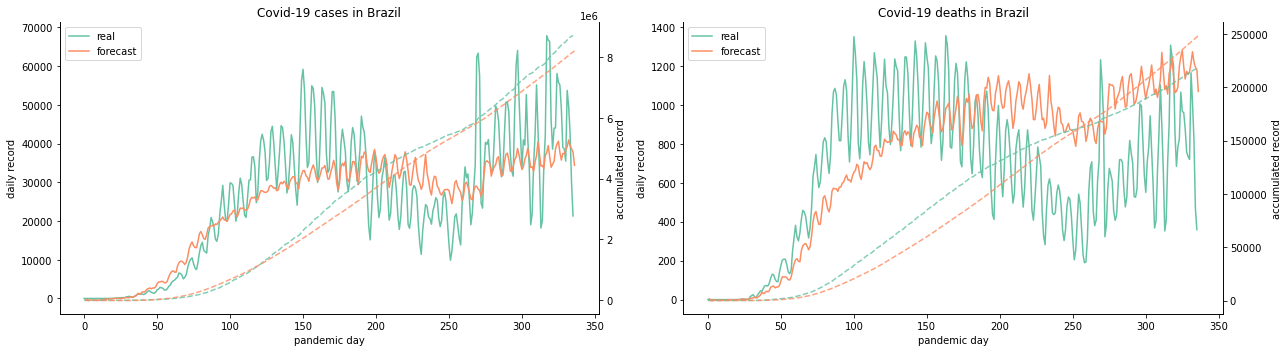




Model m2-f1:
  -> training/test loss = 0.054/0.895


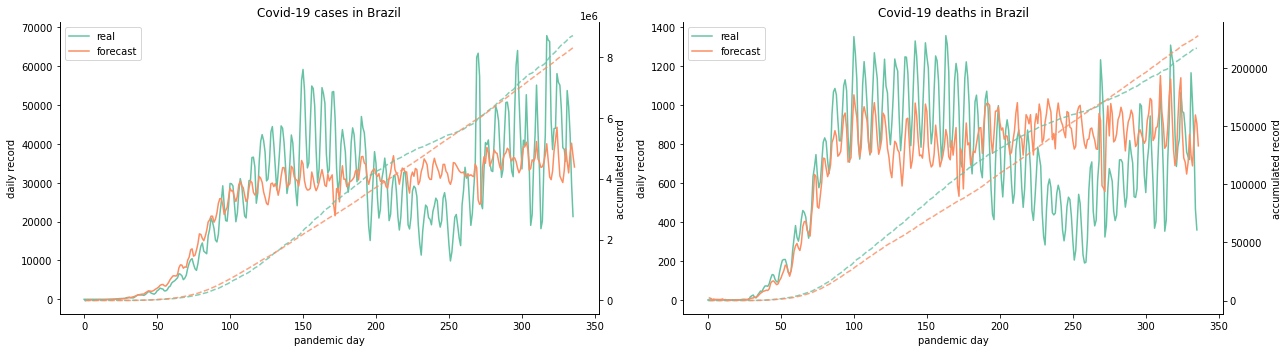




Model m2-f2:
  -> training/test loss = 0.064/0.634


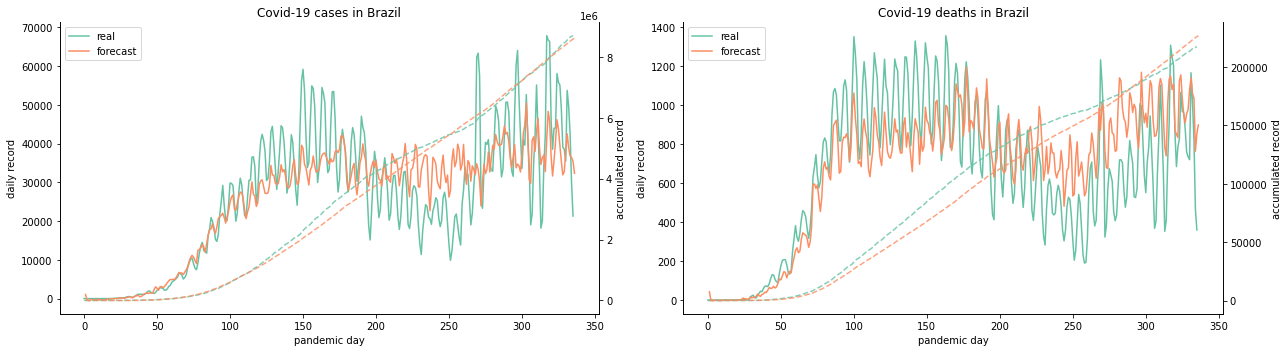




Model m2-f3:
  -> training/test loss = 0.086/0.802


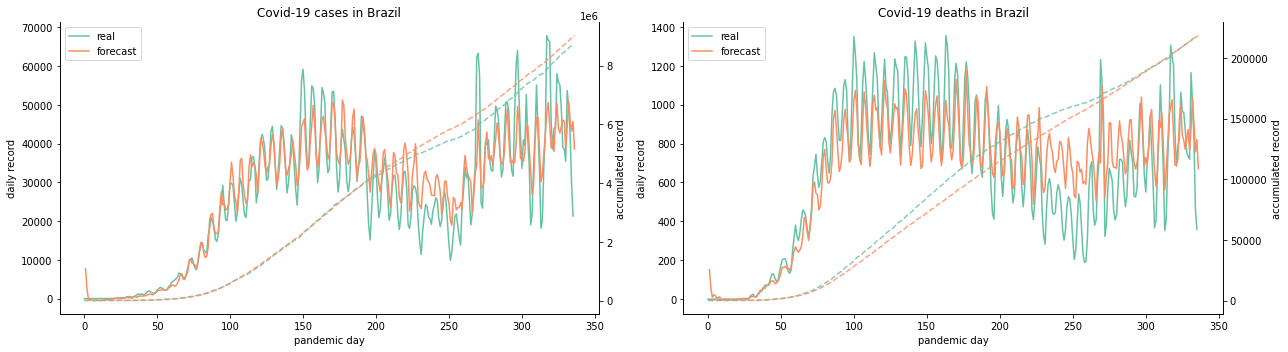




Model m2-f4:
  -> training/test loss = 0.102/0.461


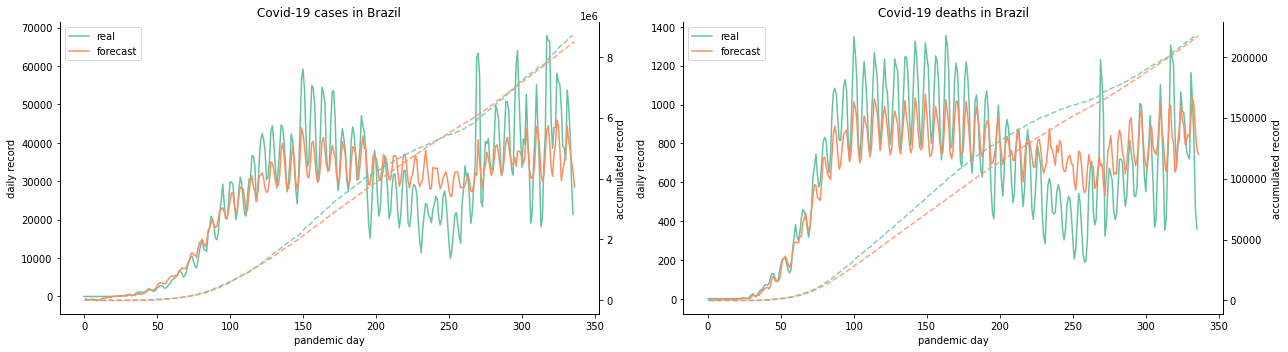




Model m2-f5:
  -> training/test loss = 0.096/0.253


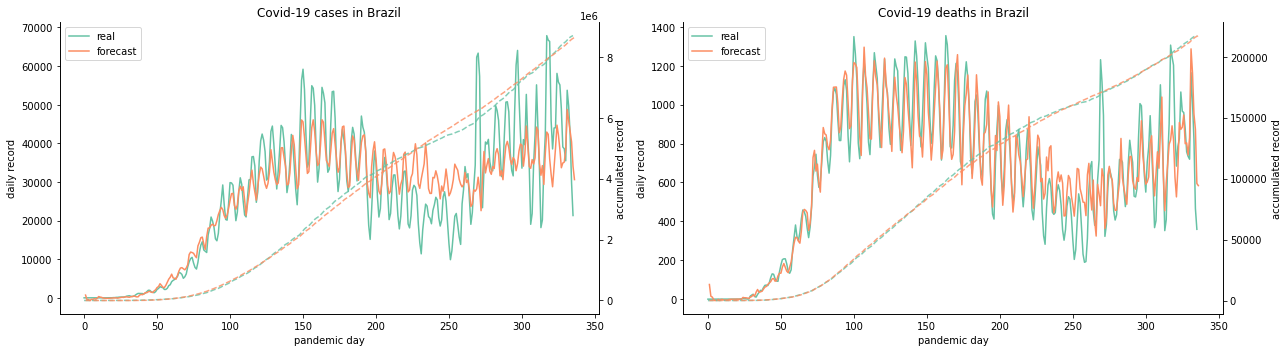




Model m2-f6:
  -> training/test loss = 0.099/0.256


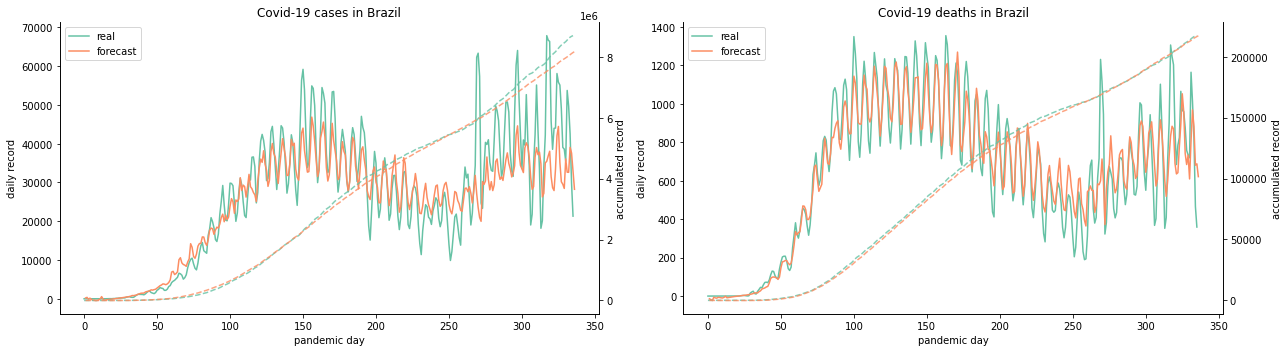




Model m2-f7:
  -> training/test loss = 0.123/0.962


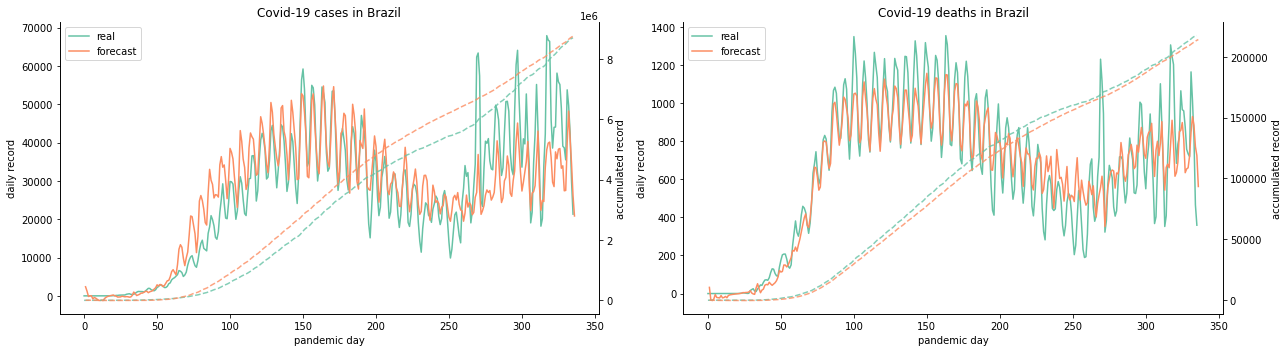




Model m2-f8:
  -> training/test loss = 0.133/0.957


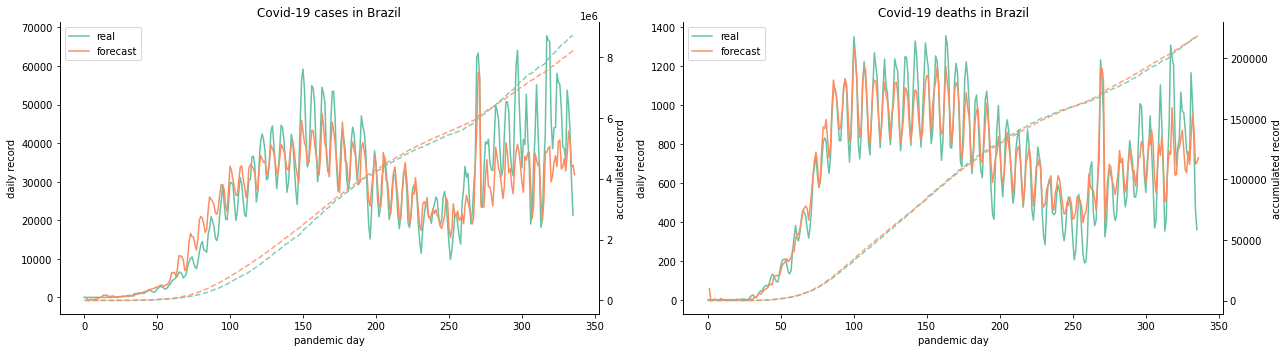




Model m2-f9:
  -> training/test loss = 0.146/1.024


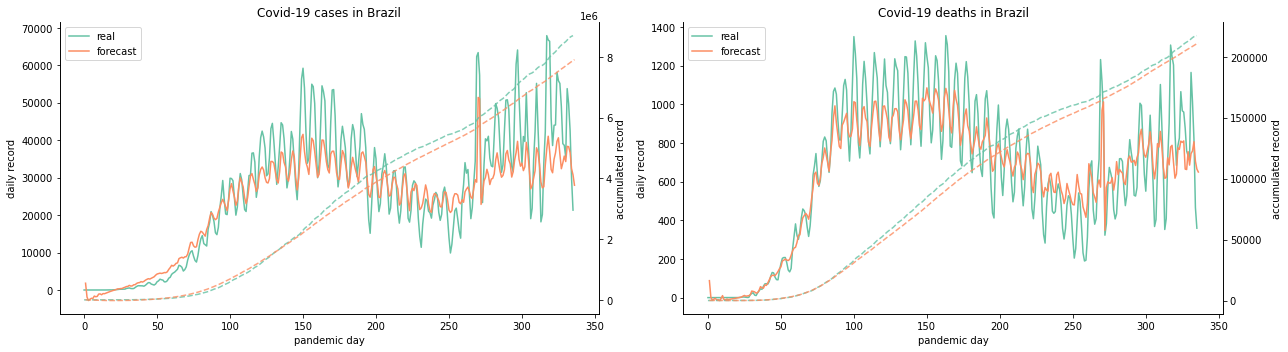

In [ ]:
# análise do modelo 2 em território nacional
recs2 = COACH.loadState(template2, 'records/m2')

for i, (net, data) in enumerate(recs2):
    tr_loss = data['loss'][0]
    te_loss = data['loss'][1]
    print('Model m2-f%i:' % (i))
    print('  -> training/test loss = %.3f/%.3f' % (tr_loss[-1], te_loss[-1]))
    oneDayForecast(net, [None], MODALS, suffix=('stGCN-m2-f' + str(i)))

In [ ]:
best2 = recs2[5][0]
for m in ['FOCO', 'RMSP', 'BAIX', 'AERO', 'SOPR', 'MPEQ']:
    oneDayForecast(best2, GEOCODE[m], MODALS, suffix='stGCN-m2_(best)')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#for t_known in [100, 150, 300, 330]:
    #nDaysForecast(best2, GEOCODE['RMSP'], MODALS, [t_known, 20])

# **Passo 5**: análise comparativa dos modelos

In [ ]:
COACH.cudaStatus()

Tue May 31 18:32:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |   1364MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# média e desvio padrão do dataset,
# calculado em cima dos valores médios
# da curva temporal por município
Xd = COACH.undoNorm(COACH.Xd, 'Xd')
mask = tc.cat([ tc.ones([1,5570], dtype=tc.bool).to(DEVICE), COACH.hab_mask ])

print('#=======#======#=====================#=====================#')
print('| PORTE |  QT  |        CASOS        |       MORTES        |')
print('#=======#======#=====================#=====================#')

t_mean = Xd.mean(0).cpu() 

for i,s in zip([0,1,2,3],['-','p','m','g']):
    #avg = Xd[ :, mask[i] ].mean([0,1]).cpu()
    #std = Xd[ :, mask[i] ].std([0,1]).cpu()
    qt = mask[i].sum()
    avg = t_mean[ mask[i], : ].mean(0)   
    std = t_mean[ mask[i], : ].std(0)
    print("|   %c   | %4i | %7.3f +/- %7.3f | %7.3f +/- %7.3f |" % 
          (s, qt, avg[0], std[0], avg[1], std[1]))
    
print('#=======#======#=====================#=====================#')

#=======#======#=====================#=====================#
| PORTE |  QT  |        CASOS        |       MORTES        |
#=======#======#=====================#=====================#
|   -   | 5570 |   4.647 +/-  26.380 |   0.116 +/-   1.062 |
|   p   | 3250 |   0.705 +/-   0.659 |   0.012 +/-   0.012 |
|   m   | 2119 |   4.613 +/-   4.883 |   0.089 +/-   0.096 |
|   g   |  201 |  68.739 +/- 121.394 |   2.077 +/-   5.218 |
#=======#======#=====================#=====================#


### Funções

In [14]:
# comparação entre os modelos de GCN
def compareGcnModels(param_list, horizon=1):
    model_loss = {} # erro dos modelos
    days = tc.tensor(range(336)) # série de dias
    mask = COACH.getMeshMask(MODALS) # máscara das malhas de conectividade

    for (net, version) in param_list:
        COACH.validation = False
        COACH.normalizeZeroMean()
        net.eval()

        # valores brutos
        TARGET = []
        OUTPUT = []

        # métricas
        MAE   = []  # mean absolute error
        sMAPE = []  # symmetric mean percentage error
        NRMSE = []  # relative root mean square error

        # avaliação das amostras de teste
        with tc.no_grad():
            for X_in, Xd in zip(COACH.getFolds('tv'), COACH.getFolds('te')):
                # obtenção do histórico corrente
                h = net.forward(X_in, COACH.Xs, COACH.A, COACH.W, mask)[1]
                # avaliação no grupo de teste
                X_tg = COACH.undoNorm(Xd)
                X_pr = COACH.undoNorm(net.forecast(Xd[:-horizon], COACH.Xs, COACH.A, COACH.W, mask, h, horizon)[0])
                # registro dos números brutos
                TARGET.append(X_tg)
                OUTPUT.append(X_pr)
                # registro dos números agregados
                loss = COACH.metrics(X_pr, X_tg)
                MAE.append(loss['MAE'])
                sMAPE.append(loss['sMAPE'])
                NRMSE.append(loss['NRMSE'])
            
            # média e desvio padrão dos K subconjuntos de teste
            #    [K,5570,2] -> [5570,2]
            name = 'stGCN-' + version
            model_loss[name] = {
                'TARGET': tc.stack(TARGET),
                'OUTPUT': tc.stack(OUTPUT),
            }

            for err, metric in zip([MAE, sMAPE, NRMSE], ['MAE', 'sMAPE', 'NRMSE']):
                stk = tc.stack(err)
                model_loss[name][metric] = stk.mean(0)
    
    # modelo >>> métrica >>> [mean, std] >>> tensor[média municipal, curva]
    return model_loss

In [15]:
def evalSktModel(net, x_in, x_tg, mu, sigma):
    n_days = x_tg.size(0)

    # valores brutos
    TARGET = tc.zeros([2,n_days])
    OUTPUT = tc.zeros([2,n_days])

    # métricas
    MAE   = tc.zeros(2)  # mean absolute error
    sMAPE = tc.zeros(2)  # symmetric mean percentage error
    NRMSE = tc.zeros(2)  # relative root mean square error
 
    # para garantir a convergência do modelo
    x_in = (x_in + 1 + mu).t()
    x_tg = (x_tg + 1).t()

    # fit do modelo
    for i in [0,1]:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            net.fit(pd.Series(x_in[i]), )

        # predição
        fh = np.arange(n_days) + x_in.size(0)
        x_pr = tc.tensor(net.predict(fh).values) - mu[i]

        # avaliação
        TARGET[i] = x_tg[i]
        OUTPUT[i] = x_pr

        cost = F.l1_loss(x_pr, x_tg[i], reduction='none')
        
        MAE[i] = cost.mean()
        sMAPE[i] = (cost / (x_tg[i].abs() + x_pr.abs())).mean()

        cost = F.mse_loss(x_pr, x_tg[i], reduction='none')
        NRMSE[i] = cost.mean().sqrt() / sigma[i]
    
    return [TARGET, OUTPUT, MAE, sMAPE, NRMSE]

In [16]:
# comparação entre os modelos do Sktime
def compareSktModels(param_list, split, geocodes=[]):
    COACH.splitTimeSeries(split[0],split[1],split[2],split[3])
    COACH.validation = False
    COACH.normalizeZeroMean()
    
    fh_days = split[2]
    model_loss = {} # erro dos modelos
    days = tc.tensor(range(336)) # série de dias
    mask = COACH.getMeshMask(MODALS) # máscara das malhas de conectividade
    mun_list = range(5570) if not len(geocodes) else [ DATASET.geocode_index[g] for g in geocodes ] # índices dos municípios

    for (net, version) in param_list:
        mb = 0 # contador de minibatches
        qt_mb = len(COACH.getFolds('tv'))

        # valores brutos
        TARGET = tc.zeros([COACH.qt_mbatch, fh_days, 5570, 2])
        OUTPUT = tc.zeros([COACH.qt_mbatch, fh_days, 5570, 2])

        # métricas
        MAE   = tc.zeros([COACH.qt_mbatch, 5570, 2])  # mean absolute error
        sMAPE = tc.zeros([COACH.qt_mbatch, 5570, 2])  # symmetric mean percentage error
        NRMSE = tc.zeros([COACH.qt_mbatch, 5570, 2])  # relative root mean square error

        ti = time.time()

        # avaliação das amostras de teste
        with tc.no_grad():
            for X_in, X_tg in zip(COACH.getFolds('tv'), COACH.getFolds('te')):
                mu = COACH.undoNorm(X_tg).mean([0,1]).cpu()
                sigma = COACH.undoNorm(X_tg).std([0,1]).cpu()
                for idx in mun_list:
                    x_in = COACH.undoNorm(X_in)[:, idx].cpu()
                    x_tg = COACH.undoNorm(X_tg)[:, idx].cpu()
                    mun_err = evalSktModel(net,x_in,x_tg,mu,sigma)

                    TARGET[mb,:,idx] = mun_err[0].t()
                    OUTPUT[mb,:,idx] = mun_err[1].t()

                    MAE[mb,idx]   = mun_err[2]
                    sMAPE[mb,idx] = mun_err[3]
                    NRMSE[mb,idx] = mun_err[4]
                    if (idx+1) % 10 == 0:
                        print('\r%-10s\t[%2i/%2i] %4i/5570' % (version, mb+1, qt_mb, idx+1), end='')
                mb += 1
            
            # média dos K subconjuntos de teste
            #    [K,5570,2] -> [5570,2]
            #model_loss[version] = [ err.mean(0) for err in [MAE, sMAPE, NRMSE] ]
            model_loss[version] = {
                'TARGET': TARGET,
                'OUTPUT': OUTPUT,
            }

            for err, metric in zip([MAE, sMAPE, NRMSE], ['MAE', 'sMAPE', 'NRMSE']):
                model_loss[version][metric] = err.mean(0)
        
        # marcação de tempo
        tf = time.time()
        print('\t %7.3f min' % ((tf-ti)/60))
    
    return model_loss

In [17]:
def exportComparison(model_loss, path=None):
    qt_mun = DATASET.graph_info['municipios']
    df_model = pd.DataFrame({
        'geocode': DATASET.geocode_list,
        'mb': np.zeros(qt_mun, dtype=np.int16),
        'fh': np.zeros(qt_mun, dtype=np.int16)
    })
    df_empy = pd.DataFrame(columns=df_model.columns)
    df_dict = {}

    for (net_version) in model_loss:
        df = df_empy.copy()
        curves = ['cases', 'deaths']
        
        for values in ['TARGET','OUTPUT']:
            stats = model_loss[net_version][values].to('cpu')
            cols = [ values+'_'+c for c in curves ] 
            df_metric = df_empy.copy()

            for i,s in enumerate(stats):
                for j,d in enumerate(s):
                    df_temp = df_model.copy().join(pd.DataFrame(data=d.numpy(), columns=cols))
                    df_temp['mb'] = i+1
                    df_temp['fh'] = j+1
                    df_metric = df_metric.append(df_temp)
            df = df.merge(df_metric, how='outer', on=['geocode','mb','fh'])
        if path is not None:
            #file_name = path + net_version + '.csv'
            file_name = path + net_version + '.parquet.gzip'
            #df.to_csv(file_name, index=False)
            df.to_parquet(file_name, compression='gzip', index=False)
            print(f'file "{file_name}" exported')
        else:
            print(f'dataframe "{file_name}" created')
            print(df)
            df_dict.update({net_version : df})
    if path is None:
        return df_dict

STATS_PATH = 'statistics/'
loss_all = {}

In [18]:
def printComparison(model_loss, latex_format=False, ufs=False):
    # cabeçalho
    print()
    print('#====#============#======#===================#===================#===================#')
    print('| UF |   MODELO   |  QT  |        MAE        |       sMAPE       |       NRMSE       |')
    print('|    |            | MUN. |   casos   mortes  |   casos   mortes  |   casos   mortes  |')
    print('#====#============#======#===================#===================#===================#')

    if not latex_format:
        output_string = '| %2s | %-10s | %4i | %7.3f : %7.3f | %7.3f : %7.3f | %7.3f : %7.3f |'
    else:
        output_string = '| %2s | %-10s | %4i | %.3f & %.3f & %.3f & %.3f & %.3f & %.3f \\\\'

    # máscara regional
    if not ufs:
        reg_list = ['>p', '>m', '>g', '>>']
        reg_mask = tc.cat([COACH.hab_mask, tc.ones([1,5570], dtype=tc.bool, device=DEVICE)])
    else:
        reg_list = list(DATASET.regional_index.keys()) + ['>p', '>m', '>g', '>>']
        reg_mask = tc.cat([ COACH.uf_mask, COACH.hab_mask, tc.ones([1,5570], dtype=tc.bool, device=DEVICE)])

    df = pd.DataFrame({'uf': reg_list, 'idx:': range(len(reg_list))})
    df = df.sort_values(by='uf')
    
    # filtragem e impressão
    for _, (uf, i) in df.iterrows():
        for (net_version) in model_loss:
            mask = reg_mask[i]
            qt_mun = mask.sum()
            # todas os minibatches, todo o horizonte de previsão, na máscara, ambas as curvas
            #metrics = set(model_loss[net_version].keys()) - set(['TARGET','OUTPUT'])
            metrics = ['MAE','sMAPE','NRMSE']
            loss = [ model_loss[net_version][m][mask].mean(0) for m in metrics ]
        
            # exibição da média dos erros
            print(output_string % (uf, net_version, qt_mun,
                loss[0][0], loss[0][1], 
                loss[1][0], loss[1][1], 
                loss[2][0], loss[2][1]))
        
        print('#====#============#======#===================#===================#===================#')

### Resultados

In [19]:
recs1 = COACH.loadState(template1, 'records/m1')
loss = compareGcnModels([
    (r[0], 'm1-f' + str(i)) for i, r in enumerate(recs1)
])
exportComparison(loss, STATS_PATH)
loss_all.update(loss)

file "statistics/stGCN-m1-f0.parquet.gzip" exported
file "statistics/stGCN-m1-f1.parquet.gzip" exported
file "statistics/stGCN-m1-f2.parquet.gzip" exported
file "statistics/stGCN-m1-f3.parquet.gzip" exported
file "statistics/stGCN-m1-f4.parquet.gzip" exported
file "statistics/stGCN-m1-f5.parquet.gzip" exported
file "statistics/stGCN-m1-f6.parquet.gzip" exported
file "statistics/stGCN-m1-f7.parquet.gzip" exported
file "statistics/stGCN-m1-f8.parquet.gzip" exported
file "statistics/stGCN-m1-f9.parquet.gzip" exported


In [ ]:
recs2 = COACH.loadState(template2, 'records/m2')
loss = compareGcnModels([
    (r[0], 'm2-f' + str(i)) for i, r in enumerate(recs2)
])
exportComparison(loss, STATS_PATH)
loss_all.update(loss)

file "statistics/stGCN-m2-f0.parquet.gzip" exported
file "statistics/stGCN-m2-f1.parquet.gzip" exported
file "statistics/stGCN-m2-f2.parquet.gzip" exported
file "statistics/stGCN-m2-f3.parquet.gzip" exported
file "statistics/stGCN-m2-f4.parquet.gzip" exported
file "statistics/stGCN-m2-f5.parquet.gzip" exported
file "statistics/stGCN-m2-f6.parquet.gzip" exported
file "statistics/stGCN-m2-f7.parquet.gzip" exported
file "statistics/stGCN-m2-f8.parquet.gzip" exported
file "statistics/stGCN-m2-f9.parquet.gzip" exported


In [ ]:
print(loss['stGCN-v1']['MAE'].size())
print(loss['stGCN-v1']['TARGET'].size())

torch.Size([5570, 2])
torch.Size([10, 25, 5570, 2])


In [ ]:
################################################################################
models = [(NaiveForecaster(strategy='last', sp=2), 'Naive-sp02')]
loss = compareSktModels(models, split=(66,20,25,False)) # approx. 17 min
exportComparison(loss, STATS_PATH)
printComparison(loss) # ignore these results, check them in script 4
loss_all.update(loss)

Naive-sp02	[10/10] 5570/5570	  16.968 min
file "dados/estatisticas/Naive-sp02.csv" exported

#====#============#======#===================#===================#===================#
| UF |   MODELO   |  QT  |        MAE        |       sMAPE       |       NRMSE       |
|    |            | MUN. |   casos   mortes  |   casos   mortes  |   casos   mortes  |
#====#============#======#===================#===================#===================#
| >> | Naive-sp02 | 5570 |   4.205 :   0.132 |   0.223 :   0.034 |   0.105 :   0.101 |
#====#============#======#===================#===================#===================#
| >g | Naive-sp02 |  201 |  48.844 :   1.644 |   0.315 :   0.201 |   1.221 :   1.231 |
#====#============#======#===================#===================#===================#
| >m | Naive-sp02 | 2119 |   4.842 :   0.149 |   0.291 :   0.053 |   0.120 :   0.115 |
#====#============#======#===================#===================#===================#
| >p | Naive-sp02 | 3250 |   1.029 : 

In [ ]:
models = [(NaiveForecaster(strategy='last', sp=TAU), 'Naive-sp'+str(TAU))]
loss = compareSktModels(models, split=(66,20,25,False)) # approx. 17 min
exportComparison(loss, STATS_PATH)
printComparison(loss) # ignore these results, check them in script 4
loss_all.update(loss)

Naive-sp14	[10/10] 5570/5570	  15.471 min
file "statistics/Naive-sp14.parquet.gzip" exported

#====#============#======#===================#===================#===================#
| UF |   MODELO   |  QT  |        MAE        |       sMAPE       |       NRMSE       |
|    |            | MUN. |   casos   mortes  |   casos   mortes  |   casos   mortes  |
#====#============#======#===================#===================#===================#
| >> | Naive-sp14 | 5570 |   4.340 :   0.134 |   0.231 :   0.035 |   0.144 :   0.155 |
#====#============#======#===================#===================#===================#
| >g | Naive-sp14 |  201 |  51.160 :   1.655 |   0.335 :   0.204 |   1.649 :   1.578 |
#====#============#======#===================#===================#===================#
| >m | Naive-sp14 | 2119 |   4.957 :   0.152 |   0.303 :   0.054 |   0.164 :   0.186 |
#====#============#======#===================#===================#===================#
| >p | Naive-sp14 | 3250 |   1.042 :

In [ ]:
################################################################################
models = [(ARIMA(order=(1,0,0)), 'ARIMA-o100')]
loss = compareSktModels(models, split=(66,20,25,False)) # approx. 3h
exportComparison(loss, STATS_PATH)
printComparison(loss) # ignore these results, check them in script 4
loss_all.update(loss)

ARIMA-o100	[10/10] 5570/5570	 172.744 min
file "dados/estatisticas/ARIMA-o100.csv" exported

#====#============#======#===================#===================#===================#
| UF |   MODELO   |  QT  |        MAE        |       sMAPE       |       NRMSE       |
|    |            | MUN. |   casos   mortes  |   casos   mortes  |   casos   mortes  |
#====#============#======#===================#===================#===================#
| >> | ARIMA-o100 | 5570 |   3.932 :   0.121 |   0.229 :   0.033 |   0.127 :   0.127 |
#====#============#======#===================#===================#===================#
| >g | ARIMA-o100 |  201 |  47.146 :   1.527 |   0.333 :   0.197 |   1.486 :   1.422 |
#====#============#======#===================#===================#===================#
| >m | ARIMA-o100 | 2119 |   4.515 :   0.135 |   0.310 :   0.052 |   0.145 :   0.145 |
#====#============#======#===================#===================#===================#
| >p | ARIMA-o100 | 3250 |   0.879 : 

In [ ]:
models = [(ARIMA(order=(1,1,0)), 'ARIMA-o110')]
loss = compareSktModels(models, split=(66,20,25,False)) # approx. 112.878 min
exportComparison(loss, STATS_PATH)
printComparison(loss) # ignore these results, check them in script 4

Arima-o110	[10/10] 5570/5570	 143.469 min

#====#============#======#===================#===================#===================#
| UF |   MODELO   |  QT  |        MAE        |       sMAPE       |       NRMSE       |
|    |            | MUN. |   casos   mortes  |   casos   mortes  |   casos   mortes  |
#====#============#======#===================#===================#===================#
| >> | Arima-o110 | 5570 |   4.523 :   0.143 |   0.232 :   0.036 |   0.140 :   0.148 |
#====#============#======#===================#===================#===================#
| >g | Arima-o110 |  201 |  52.806 :   1.803 |   0.325 :   0.208 |   1.612 :   1.621 |
#====#============#======#===================#===================#===================#
| >m | Arima-o110 | 2119 |   5.191 :   0.159 |   0.301 :   0.056 |   0.161 :   0.173 |
#====#============#======#===================#===================#===================#
| >p | Arima-o110 | 3250 |   1.102 :   0.029 |   0.180 :   0.012 |   0.036 :   0.040 |


In [ ]:
################################################################################
models = [(ExponentialSmoothing(trend="add", seasonal="mul", sp=2), 'ExpSm-sp02')]
loss = compareSktModels(models, split=(66,20,25,False)) # approx. 4h15
exportComparison(loss, STATS_PATH)
printComparison(loss) # ignore these results, check them in script 4
loss_all.update(loss)

ExpSm-sp02	[10/10] 5570/5570	 256.345 min
file "dados/estatisticas/ExpSm-sp02.csv" exported

#====#============#======#===================#===================#===================#
| UF |   MODELO   |  QT  |        MAE        |       sMAPE       |       NRMSE       |
|    |            | MUN. |   casos   mortes  |   casos   mortes  |   casos   mortes  |
#====#============#======#===================#===================#===================#
| >> | ExpSm-sp02 | 5570 |   5.190 :   0.169 |   0.264 :   0.043 |   0.158 :   0.168 |
#====#============#======#===================#===================#===================#
| >g | ExpSm-sp02 |  201 |  59.346 :   1.993 |   0.340 :   0.255 |   1.781 :   1.813 |
#====#============#======#===================#===================#===================#
| >m | ExpSm-sp02 | 2119 |   6.033 :   0.195 |   0.352 :   0.066 |   0.185 :   0.195 |
#====#============#======#===================#===================#===================#
| >p | ExpSm-sp02 | 3250 |   1.290 : 

# **Passo 6**: previsão continuada

In [ ]:
# previsão de número de casos e mortes de 1 meses depois
def forecastDate(model, f_date, delay=0):
    with tc.no_grad():
        # horizonte de dias a serem previstos
        future_date = np.datetime64(f_date)
        last_known = np.datetime64('2021-01-25')
        horizon = (future_date - last_known).item().days + delay

        # previsão continuada
        Y, H = model.forecast(COACH.Xd, 
                            COACH.Xs, 
                            COACH.A, 
                            COACH.W, 
                            COACH.getMeshMask(MODALS), 
                            qt_days=horizon)
        
        # dados acumulados até último dia de interesse
        COACH.undoNorm(Y, inplace=True)
        return COACH.cumulative(Y)[-1]

# soma de todos os municípios p/ ter os números nacionais
net = COACH.loadState(template1, 'records/m1')[4][0]
#net = COACH.loadState(template1, 'records/m1x')[0][0]
pred = forecastDate(net, '2021-02-10', 2).sum(0).cpu()
real = tc.tensor([9662305, 234945], dtype=tc.float)

print("\n\nPREVISÃO DE CASOS E MORTES DE 1 MÊS À FRENTE")
print("==============================================================")
print("Números reais do dia 25/02/2021:    ", real.int())
print("Números estimados para o mesmo dia: ", pred.int())
print("Erro relativo na previsão:          ", (real - pred)/real)



PREVISÃO DE CASOS E MORTES DE 1 MÊS À FRENTE
Números reais do dia 25/02/2021:     tensor([9662305,  234945], dtype=torch.int32)
Números estimados para o mesmo dia:  tensor([8845673,  219788], dtype=torch.int32)
Erro relativo na previsão:           tensor([0.0845, 0.0645])


# **ETC**

In [ ]:
################################################################################
# Tempo estimado: 5min
res = compareSktModels([
    (NaiveForecaster(strategy='last', sp=2), 'Naive.02')
], split=(66,20,25,False))

MAE   = res['Naive.02'][0]
sMAPE = res['Naive.02'][1]
NRMSE = res['Naive.02'][2]

print(MAE.isnan()[:].sum(0))
print(sMAPE.isnan()[:].sum(0))
print(NRMSE.isnan()[:].sum(0))

In [ ]:
# comparação entre os modelos do ScikitLearn
def compareSktModels(model_family, geocode, split):
    print('#============#=======#=====================#=====================#=====================#')
    print('|   MODELO   | TEMPO |         MAE         |        sMAPE        |        NRMSE        |')
    print('|            | (min) |   casos     mortes  |   casos     mortes  |   casos     mortes  |')
    print('#============#=======#=====================#=====================#=====================#')
    
    output_string = '| %10s | %5.1f | %8.3f : %8.3f | %8.3f : %8.3f | %8.3f : %8.3f |'

    COACH.splitTimeSeries(split[0],split[1],split[2],split[3])
    COACH.normalizeZeroMean()
    COACH.validation = False

    fit_time = {}
    model_loss = {} # erro dos modelos
    days = tc.tensor(range(336)) # série de dias
    offset = 100 # para garantir a convergência do modelo
    idx = DATASET.geocode_index[geocode] # índice do município

    for param_list in model_family:
        for (net, version) in param_list:

            # métricas
            MAE   = [ [], [] ]  # mean absolute error
            sMAPE = [ [], [] ]  # symmetric mean percentage error
            NRMSE = [ [], [] ]  # relative root mean square error
            
            fit_time[version] = 0
            ti = time.time()

            for i in [0,1]:
                # avaliação das amostras de teste
                for X_in, X_tg in zip(COACH.getMinibatches('tr'), COACH.getMinibatches('te')):

                    # filtragem por município e curva
                    X_in = COACH.undoNorm(X_in)[:, idx, i].cpu()
                    X_tg = COACH.undoNorm(X_tg)[:, idx, i].cpu()

                    # fit do modelo
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore")
                        net.fit(pd.Series(X_in + offset))

                    # predição e avaliação
                    with tc.no_grad():
                        fh = np.arange(X_tg.size(0)) + X_in.size(0)
                        X_pr = tc.tensor(net.predict(fh).values) - offset

                        cost = F.l1_loss(X_pr, X_tg, reduction='none')
                        MAE[i].append( cost.mean() )
                        sMAPE[i].append( (cost / (X_tg.abs() + X_pr.abs())).mean() )

                        cost = F.mse_loss(X_pr, X_tg, reduction='none')
                        NRMSE[i].append( cost.mean().sqrt() / X_tg.std() )
              
            tf = time.time()
            fit_time[version] = (tf-ti)%60

            # média dos K subconjuntos de teste
            #    [2,K] -> [2]
            MAE   = [ tc.stack(err) for err in MAE ]
            sMAPE = [ tc.stack(err) for err in sMAPE ]
            NRMSE = [ tc.stack(err) for err in NRMSE ]
            model_loss[version] = [ tc.stack(err).t().mean(0) for err in [MAE, sMAPE, NRMSE] ]
    
    # exibição da média dos erros
    for param_list in model_family:
        for (_, version) in param_list:
            loss_avg = model_loss[version]
            print(output_string % (version, fit_time[version], 
                loss_avg[0][0], loss_avg[0][1], 
                loss_avg[1][0], loss_avg[1][1], 
                loss_avg[2][0], loss_avg[2][1]))
        
        print('#============#=======#=====================#=====================#=====================#')

################################################################################
compareSktModels([
    [(NaiveForecaster(strategy='last', sp=2), 'Naive.02'),
     (NaiveForecaster(strategy='last', sp=7), 'Naive.07'),
     (NaiveForecaster(strategy='last', sp=TAU), 'Naive.14')],
    [(ExponentialSmoothing(trend="add", seasonal="mul", sp=2), 'ExpSmtn.02'),
     (ExponentialSmoothing(trend="add", seasonal="mul", sp=7), 'ExpSmtn.07'),
     (ExponentialSmoothing(trend="add", seasonal="mul", sp=TAU), 'ExpSmtn.14')]#,
    #[(AutoARIMA(suppress_warnings=True, sp=2), 'Arima.02'),
    # (AutoARIMA(suppress_warnings=True, sp=7), 'Arima.07'),
    # (AutoARIMA(suppress_warnings=True, sp=TAU), 'Arima.14')]
], GEOCODE['FOCO'][4], (66,20,25, False)) 

In [ ]:
# média e desvio padrão do dataset
Xd = COACH.undoNorm(COACH.Xd, 'Xd')
mask = tc.cat([ tc.ones([1,5570], dtype=tc.bool).to(DEVICE), COACH.hab_mask ])

for i,s in zip([0,1,2,3],['-','p','m','g']):
    print('\n>>> PORTE (%s):' % s)
    print(' | mun =', mask[i].sum().item())
    print(' | avg =', Xd[ :, mask[i] ].mean([0,1]).cpu())
    print(' | std =', Xd[ :, mask[i] ].std([0,1]).cpu())


>>> PORTE (-):
 | mun = 5570
 | avg = tensor([4.6469, 0.1161])
 | std = tensor([37.2054,  1.4247])

>>> PORTE (p):
 | mun = 3250
 | avg = tensor([0.7050, 0.0123])
 | std = tensor([2.1018, 0.0716])

>>> PORTE (m):
 | mun = 2119
 | avg = tensor([4.6133, 0.0893])
 | std = tensor([12.3961,  0.2890])

>>> PORTE (g):
 | mun = 201
 | avg = tensor([68.7389,  2.0774])
 | std = tensor([179.7479,   7.1592])


In [ ]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import warnings

In [ ]:
# comparação entre os modelos do ScikitLearn
def compareSktModels(model_family, geocode, split):
    print('#============#=======#=====================#=====================#=====================#')
    print('|   MODELO   | TEMPO |         MAE         |        sMAPE        |        NRMSE        |')
    print('|            | (min) |   casos     mortes  |   casos     mortes  |   casos     mortes  |')
    print('#============#=======#=====================#=====================#=====================#')
    
    output_string = '| %10s | %5.1f | %8.3f : %8.3f | %8.3f : %8.3f | %8.3f : %8.3f |'

    COACH.splitTimeSeries(split[0],split[1],split[2],split[3])
    COACH.normalizeZeroMean()
    COACH.validation = False

    fit_time = {}
    model_loss = {} # erro dos modelos
    days = tc.tensor(range(336)) # série de dias
    offset = 100 # para garantir a convergência do modelo
    idx = DATASET.geocode_index[geocode] # índice do município

    for param_list in model_family:
        for (net, version) in param_list:

            # métricas
            MAE   = [ [], [] ]  # mean absolute error
            sMAPE = [ [], [] ]  # symmetric mean percentage error
            NRMSE = [ [], [] ]  # relative root mean square error
            
            fit_time[version] = 0
            ti = time.time()

            for i in [0,1]:
                # avaliação das amostras de teste
                for X_in, X_tg in zip(COACH.getMinibatches('tr'), COACH.getMinibatches('te')):

                    # filtragem por município e curva
                    X_in = COACH.undoNorm(X_in)[:, idx, i].cpu()
                    X_tg = COACH.undoNorm(X_tg)[:, idx, i].cpu()

                    # fit do modelo
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore")
                        net.fit(pd.Series(X_in + offset))

                    # predição e avaliação
                    with tc.no_grad():
                        fh = np.arange(X_tg.size(0)) + X_in.size(0)
                        X_pr = tc.tensor(net.predict(fh).values) - offset

                        cost = F.l1_loss(X_pr, X_tg, reduction='none')
                        MAE[i].append( cost.mean() )
                        sMAPE[i].append( (cost / (X_tg.abs() + X_pr.abs())).mean() )

                        cost = F.mse_loss(X_pr, X_tg, reduction='none')
                        NRMSE[i].append( cost.mean().sqrt() / X_tg.std() )
            
            tf = time.time()
            fit_time[version] = (tf-ti)/60

            # média dos K subconjuntos de teste
            #    [2,K] -> [2]
            MAE   = [ tc.stack(err) for err in MAE ]
            sMAPE = [ tc.stack(err) for err in sMAPE ]
            NRMSE = [ tc.stack(err) for err in NRMSE ]
            model_loss[version] = [ tc.stack(err).t().mean(0) for err in [MAE, sMAPE, NRMSE] ]
    
    # exibição da média dos erros
    for param_list in model_family:
        for (_, version) in param_list:
            loss_avg = model_loss[version]
            print(output_string % (version, fit_time[version], 
                loss_avg[0][0], loss_avg[0][1], 
                loss_avg[1][0], loss_avg[1][1], 
                loss_avg[2][0], loss_avg[2][1]))
        
        print('#============#=======#=====================#=====================#=====================#')

################################################################################
compareSktModels([
    [(NaiveForecaster(strategy='last', sp=2), 'Naive.02'),
     (NaiveForecaster(strategy='last', sp=7), 'Naive.07'),
     (NaiveForecaster(strategy='last', sp=TAU), 'Naive.14')],
    [(ExponentialSmoothing(trend="add", seasonal="mul", sp=2), 'ExpSmtn.02'),
     (ExponentialSmoothing(trend="add", seasonal="mul", sp=7), 'ExpSmtn.07'),
     (ExponentialSmoothing(trend="add", seasonal="mul", sp=TAU), 'ExpSmtn.14')],
    [(ARIMA(order=(1,0,0)), 'Arima.100'),
     (ARIMA(order=(1,0,1)), 'Arima.101'),
     (ARIMA(order=(1,0,2)), 'Arima.102')]
], GEOCODE['FOCO'][4], (66,20,25,False))

#============#=======#=====================#=====================#=====================#
|   MODELO   | TEMPO |         MAE         |        sMAPE        |        NRMSE        |
|            | (min) |   casos     mortes  |   casos     mortes  |   casos     mortes  |
#============#=======#=====================#=====================#=====================#
|   Naive.02 |   0.0 |  408.032 :    8.811 |    0.268 :    0.322 |    2.544 :    2.235 |
|   Naive.07 |   0.0 |  463.052 :    8.580 |    0.295 :    0.324 |    2.971 :    2.376 |
|   Naive.14 |   0.0 |  500.923 :    9.317 |    0.318 :    0.346 |    3.254 :    2.656 |
#============#=======#=====================#=====================#=====================#
| ExpSmtn.02 |   0.1 | 1444.837 :   21.769 |    0.340 :    0.412 |    8.265 :    4.862 |
| ExpSmtn.07 |   0.1 | 1228.573 :   20.519 |    0.313 :    0.408 |    7.525 :    4.866 |
| ExpSmtn.14 |   0.1 |  934.174 :   22.636 |    0.276 :    0.449 |    5.852 :    5.587 |
#============#=======

In [ ]:
compareSktModels([
    [(ARIMA(seasonal_order=(0,0,0,2)), 'Arima.02'),
     (ARIMA(seasonal_order=(0,0,0,7)), 'Arima.07'),
     (ARIMA(seasonal_order=(0,0,0,TAU)), 'Arima.14')]
], GEOCODE['FOCO'][4], (66,20,25, False)) # previsão em Brasília (DF)

#============#=======#=====================#=====================#=====================#
|   MODELO   | TEMPO |         MAE         |        sMAPE        |        NRMSE        |
|            | (min) |   casos     mortes  |   casos     mortes  |   casos     mortes  |
#============#=======#=====================#=====================#=====================#
|   Arima.02 |   2.2 |  387.040 :    9.493 |    0.269 :    0.377 |    2.029 :    2.200 |
|   Arima.07 |   2.2 |  387.040 :    9.493 |    0.269 :    0.377 |    2.029 :    2.200 |
|   Arima.14 |   2.2 |  387.040 :    9.493 |    0.269 :    0.377 |    2.029 :    2.200 |
#============#=======#=====================#=====================#=====================#


In [ ]:
# teste usando múltiplas DoubleGatedGNN como se fossem canais
# e então aplicando a convolução de kernel_size=1 como se fosse
# uma combinação linear dos resultados obtidos cada rede
"""
class MultiFreqGNN(tc.nn.Module):

    def __init__(self, params, spectre):
        super(MultiFreqGNN, self).__init__()

        self.channels = len(spectre)
        self.output = params['dim_vertice'] - 1
        self.input = self.output * len(spectre)

        self.gnn = tc.nn.ModuleList([ DoubleGatedGNN(params, freq) for freq in spectre ])
        self.filter = tc.nn.Sequential(
            # [L1] (5570x3)@C -> (5570x3)@1
            tc.nn.Conv2d(self.channels, out_channels=1, kernel_size=1),
            tc.nn.ReLU()
        )
    
    def forward(self, X, A):
        Z = []
        for net in self.gnn:
            Z.append(net(X, A))
        Z = tc.stack(Z, dim=1)
        # combinação linear dos resultados de cada rede
        Y = self.filter(Z)
        return Y.squeeze()
        

#tc.cuda.empty_cache()

SPECTRE = [8, 14]
tc.manual_seed(RANDOM_SEED)
model2 = MultiFreqGNN(DATASET.graph_info, SPECTRE).to(DEVICE)
optim2 = tc.optim.Adam(model2.parameters(), lr=1e-3)

logger.reset(1000, 50)
logger.fit(model2, optim2, CHANNEL)
logger.plotCosts()

rec2 = logger.getState()
logger.analyze(model2, geocodes)
"""